In [1]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import linregress
from scipy.stats import pearsonr
from scipy.stats import f_oneway, kruskal
from scipy.stats import shapiro, ttest_ind, mannwhitneyu
from statsmodels.distributions.empirical_distribution import ECDF

In [2]:
# Read in clean HG dataset
cleaned_visits = pd.read_excel('manually_cleaned_visits_1.19.25.xlsx')

In [3]:
cleaned_visits.head()

,ID,Date,Visit_Number,TCF7L2,GDF15,IGFBP7,EGA_Weeks,Race,HELP,PUQE,Prepregnancy_Weight,Current_Weight,Weight_Change_from_Prepregnancy,PUQE_Severity,HELP_Severity,Weight_Change_from_Last_Visit
0,AT22,2023-12-11,2,NaN,3624.286686,174251.1375,6.6,black,26.0,9.0,180.0,167.0,-13.0,Medium,Medium,0.0
1,AT22,2023-12-07,1,NaN,2788.814993,165697.5510,6.0,black,36.0,11.0,180.0,167.0,-13.0,Medium,High,NaN
2,CA11,2023-09-14,1,NaN,16489.728550,59624.3885,12.5,white,40.0,NaN,235.0,211.6,-23.4,Unknown,High,NaN
3,CC22,2023-11-06,1,NaN,12238.072545,79905.1745,6.6,white,41.0,NaN,107.0,101.4,-5.6,Unknown,High,NaN
4,DE27,2023-11-20,1,NaN,8116.779872,83499.0715,13.0,white,27.0,NaN,260.0,267.2,7.2,Unknown,Medium,NaN


# EDA

## Protein Levels by Gestational Age (EGA)

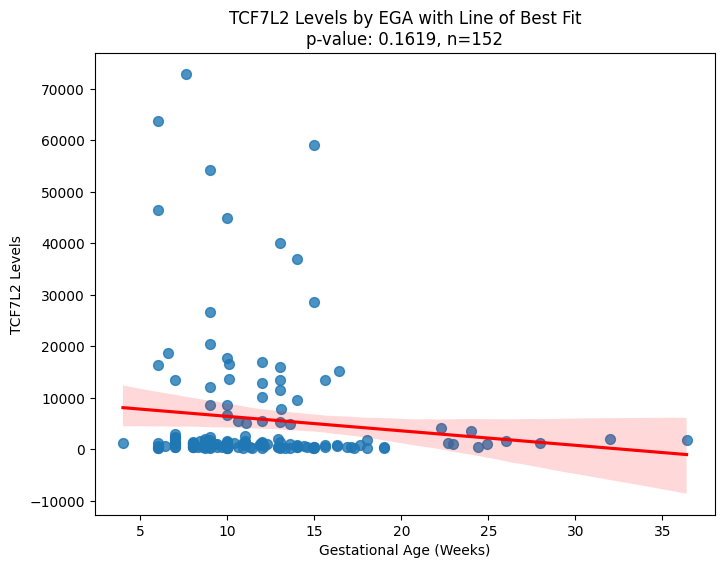

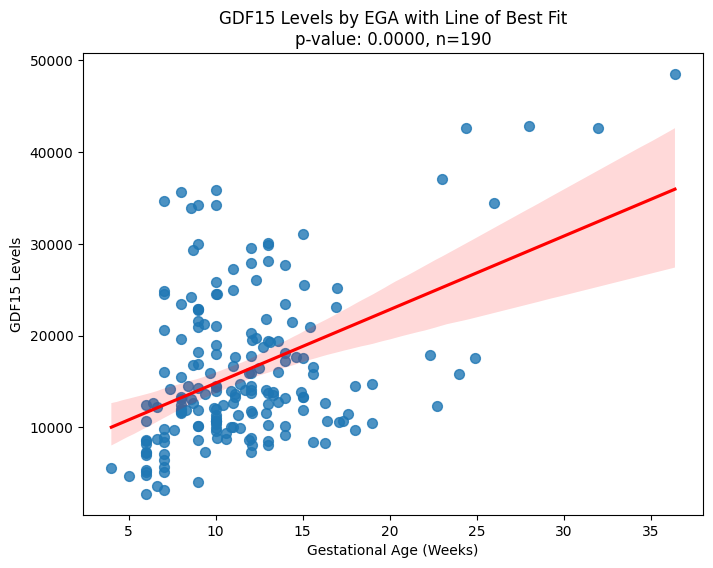

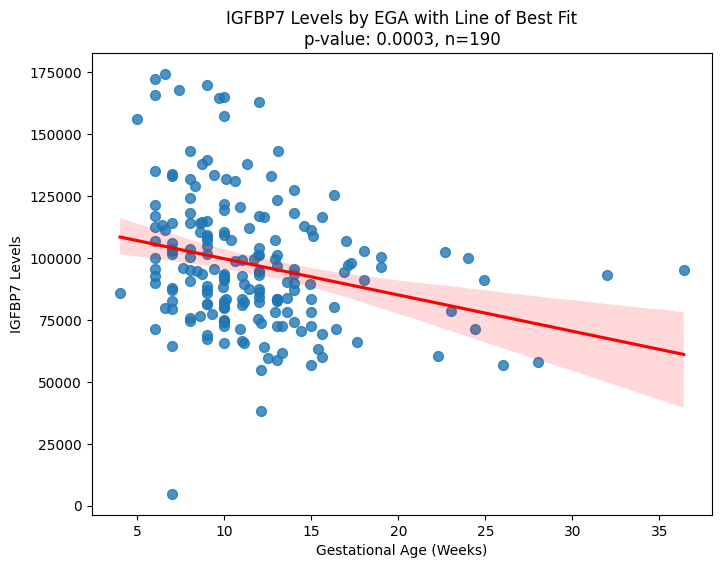

In [4]:
proteins = ['TCF7L2', 'GDF15', 'IGFBP7']

for protein in proteins:
    plt.figure(figsize=(8, 6))

    # Drop rows where EGA or the current protein level is NaN
    clean_data = cleaned_visits.dropna(subset=['EGA_Weeks', protein])

    # Scatter plot with line of best fit
    sns.regplot(x='EGA_Weeks', y=protein, data=clean_data, scatter_kws={'s': 50}, line_kws={'color': 'red'})
    
    # Calculate the p-value and sample size (n)
    slope, intercept, r_value, p_value, std_err = linregress(clean_data['EGA_Weeks'], clean_data[protein])
    sample_size = clean_data.shape[0]  # Number of valid data points (rows)

    # Display the p-value and sample size (n) in the plot
    plt.title(f"{protein} Levels by EGA with Line of Best Fit\np-value: {p_value:.4f}, n={sample_size}")
    plt.xlabel("Gestational Age (Weeks)")
    plt.ylabel(f"{protein} Levels")
    
    # Show the plot
    plt.show()

## GDF15 vs IGFBP7 by PUQE and HELP score severity
* Include correlation coefficient and p-value to see if significant relationship

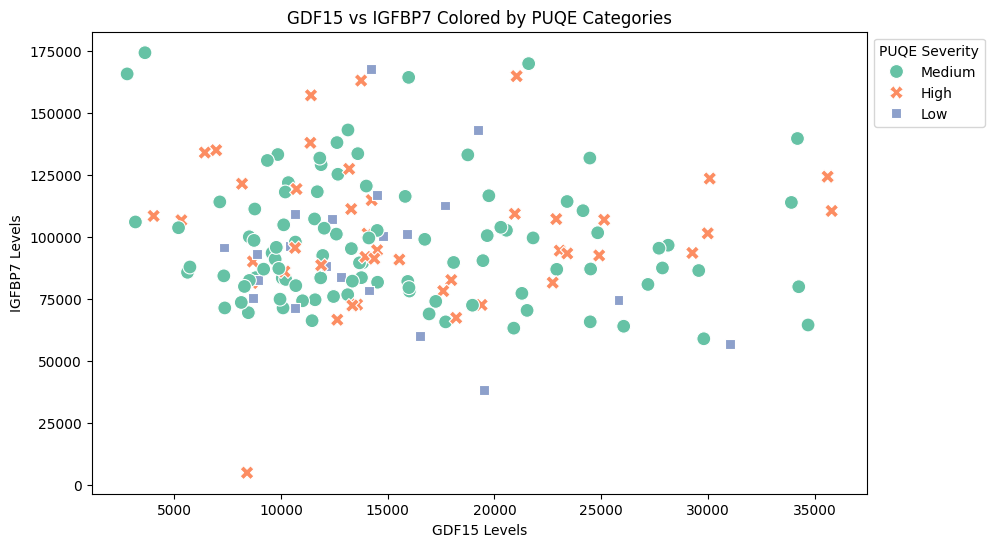

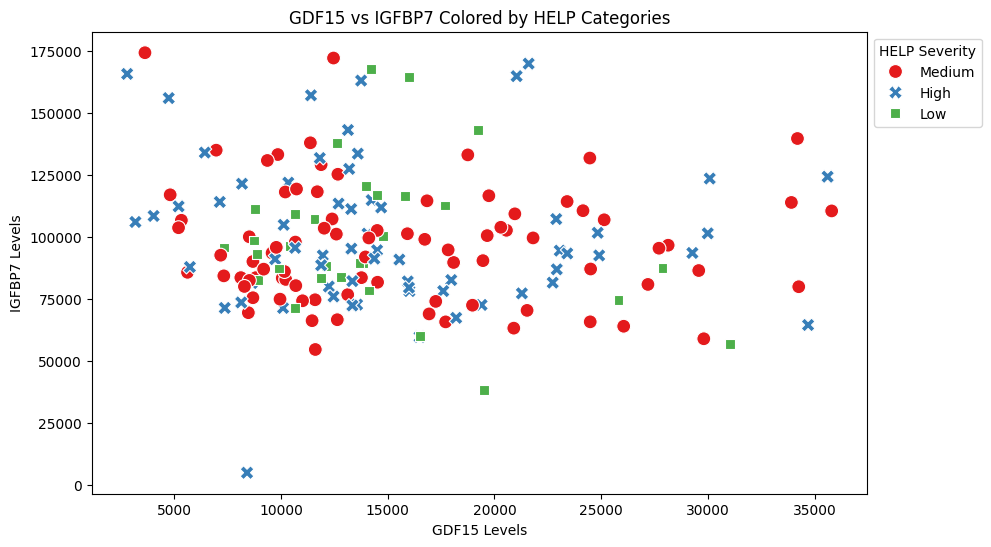

In [5]:
# Filter out 'Unknown' values for PUQE and HELP categories
filtered_puqe_df = cleaned_visits[cleaned_visits['PUQE_Severity'] != "Unknown"]
filtered_help_df = cleaned_visits[cleaned_visits['HELP_Severity'] != "Unknown"]

# Filter out rows with missing protein levels
filtered_puqe_df = filtered_puqe_df.dropna(subset=['GDF15', 'IGFBP7'])
filtered_help_df = filtered_help_df.dropna(subset=['GDF15', 'IGFBP7'])

# Filter out EGA > 20 weeks
filtered_puqe_ega_df = filtered_puqe_df[filtered_puqe_df['EGA_Weeks'] < 20]
filtered_help_ega_df = filtered_help_df[filtered_help_df['EGA_Weeks'] < 20]

# Scatter plot for PUQE (without 'Unknown')
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='GDF15', 
    y='IGFBP7', 
    hue='PUQE_Severity',  # Color by PUQE category
    data=filtered_puqe_ega_df,  # Use filtered dataset
    palette='Set2',
    style='PUQE_Severity',  # Optional: use different markers for clarity
    s=100  # Adjust size of points
)
plt.title("GDF15 vs IGFBP7 Colored by PUQE Categories")
plt.xlabel("GDF15 Levels")
plt.ylabel("IGFBP7 Levels")
plt.legend(title="PUQE Severity", loc="upper left", bbox_to_anchor=(1, 1))
plt.show()

# Scatter plot for HELP (without 'Unknown')
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='GDF15', 
    y='IGFBP7', 
    hue='HELP_Severity',  # Color by HELP category
    data=filtered_help_ega_df, 
    palette='Set1',
    style='HELP_Severity',  # Optional: use different markers
    s=100
)
plt.title("GDF15 vs IGFBP7 Colored by HELP Categories")
plt.xlabel("GDF15 Levels")
plt.ylabel("IGFBP7 Levels")
plt.legend(title="HELP Severity", loc="upper left", bbox_to_anchor=(1, 1))
plt.show()

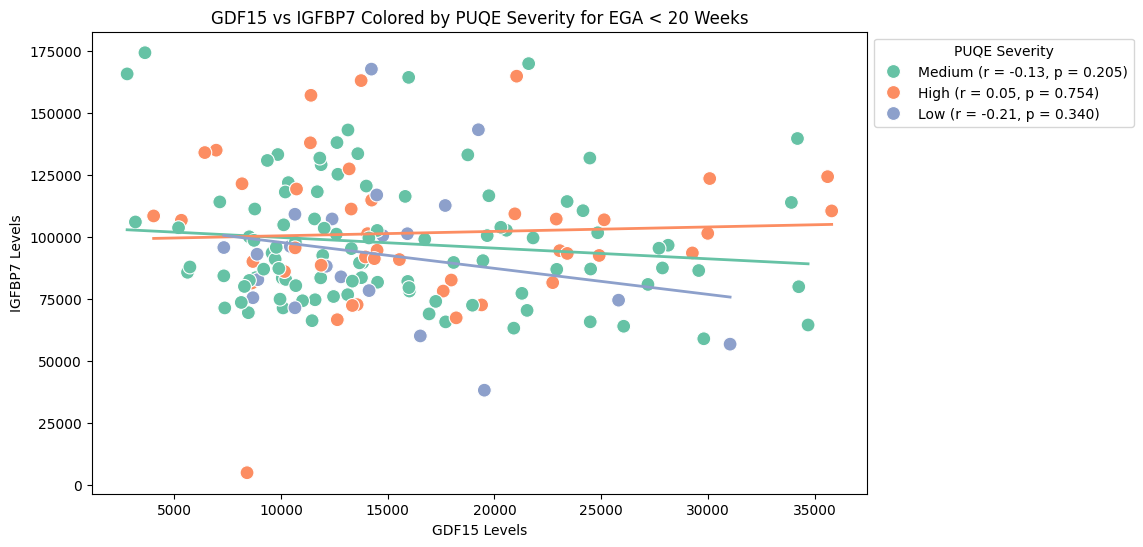

In [6]:
# Filter out 'Unknown' values for PUQE and HELP categories
filtered_puqe_df = cleaned_visits[cleaned_visits['PUQE_Severity'] != "Unknown"]
filtered_help_df = cleaned_visits[cleaned_visits['HELP_Severity'] != "Unknown"]

# Filter out rows with missing protein levels
filtered_puqe_df = filtered_puqe_df.dropna(subset=['GDF15', 'IGFBP7'])
filtered_help_df = filtered_help_df.dropna(subset=['GDF15', 'IGFBP7'])

# Filter out EGA > 20 weeks
filtered_puqe_ega_df = filtered_puqe_df[filtered_puqe_df['EGA_Weeks'] < 20]
filtered_help_ega_df = filtered_help_df[filtered_help_df['EGA_Weeks'] < 20]

# Create a list of colors for each severity category
severity_palette = sns.color_palette('Set2', n_colors=len(filtered_puqe_ega_df['PUQE_Severity'].unique()))

# Initialize a dictionary to store correlation results for each category
correlation_results = {}

# Scatter plot with line of best fit
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='GDF15', 
    y='IGFBP7', 
    hue='PUQE_Severity', 
    data=filtered_puqe_ega_df, 
    palette='Set2', 
    s=100
)

# Add line of best fit and p-value annotation for each PUQE_Severity category
for idx, category in enumerate(filtered_puqe_ega_df['PUQE_Severity'].unique()):
    category_data = filtered_puqe_ega_df[filtered_puqe_ega_df['PUQE_Severity'] == category]
    
    # Calculate the regression line with color based on severity
    sns.regplot(
        x='GDF15', 
        y='IGFBP7', 
        data=category_data, 
        scatter=False,  # Don't plot points again
        line_kws={'color': severity_palette[idx], 'lw': 2},  # Set line color based on category
        ci=None  # Remove confidence interval shading
    )
    
    # Calculate the correlation and p-value
    x = category_data['GDF15']
    y = category_data['IGFBP7']
    
    if len(x.dropna()) > 1 and len(y.dropna()) > 1:
        corr, p_value = pearsonr(x, y)
        correlation_results[category] = f"r = {corr:.2f}, p = {p_value:.3f}"  # Store the correlation and p-value for this category

# Add the legend with correlation results
handles, labels = plt.gca().get_legend_handles_labels()

# Update legend labels to include the correlation and p-value results
new_labels = [f"{label} ({correlation_results.get(label, 'n/a')})" for label in labels]

# Set the new legend
plt.legend(handles=handles, labels=new_labels, title="PUQE Severity", loc="upper left", bbox_to_anchor=(1, 1))

# Set plot title and labels
plt.title("GDF15 vs IGFBP7 Colored by PUQE Severity for EGA < 20 Weeks")
plt.xlabel("GDF15 Levels")
plt.ylabel("IGFBP7 Levels")

# Show the plot
plt.show()

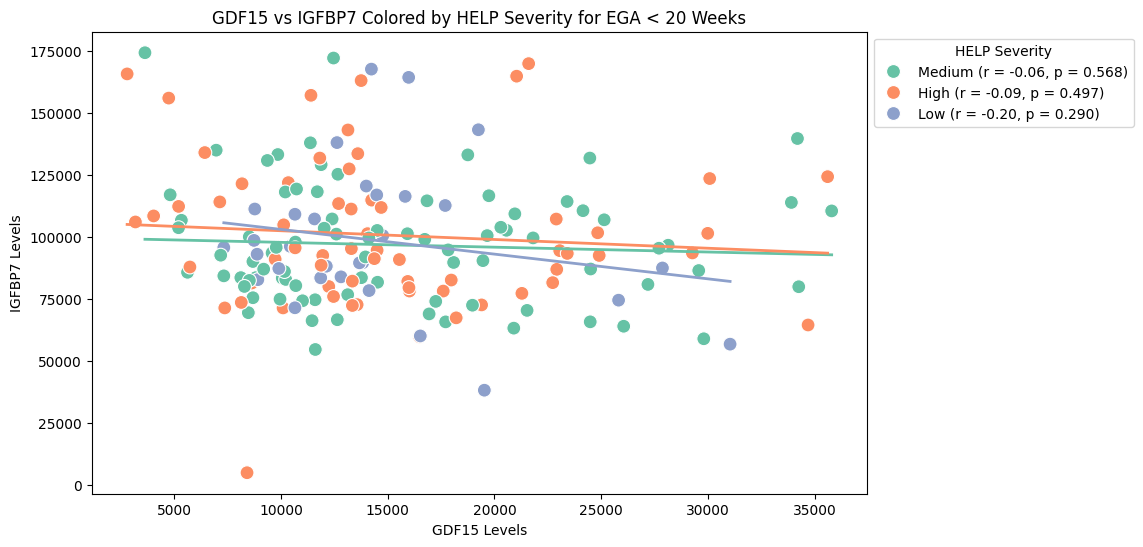

In [7]:
# Filter out 'Unknown' values for PUQE and HELP categories
filtered_puqe_df = cleaned_visits[cleaned_visits['PUQE_Severity'] != "Unknown"]
filtered_help_df = cleaned_visits[cleaned_visits['HELP_Severity'] != "Unknown"]

# Filter out rows with missing protein levels
filtered_puqe_df = filtered_puqe_df.dropna(subset=['GDF15', 'IGFBP7'])
filtered_help_df = filtered_help_df.dropna(subset=['GDF15', 'IGFBP7'])

# Filter out EGA > 20 weeks
filtered_puqe_ega_df = filtered_puqe_df[filtered_puqe_df['EGA_Weeks'] < 20]
filtered_help_ega_df = filtered_help_df[filtered_help_df['EGA_Weeks'] < 20]

# Create a list of colors for each severity category
severity_palette = sns.color_palette('Set2', n_colors=len(filtered_help_ega_df['HELP_Severity'].unique()))

# Initialize a dictionary to store correlation results for each category
correlation_results = {}

# Scatter plot with line of best fit
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='GDF15', 
    y='IGFBP7', 
    hue='HELP_Severity', 
    data=filtered_help_ega_df, 
    palette='Set2', 
    s=100
)

# Add line of best fit and p-value annotation for each HELP_Severity category
for idx, category in enumerate(filtered_help_ega_df['HELP_Severity'].unique()):
    category_data = filtered_help_ega_df[filtered_help_ega_df['HELP_Severity'] == category]
    
    # Calculate the regression line with color based on severity
    sns.regplot(
        x='GDF15', 
        y='IGFBP7', 
        data=category_data, 
        scatter=False,  # Don't plot points again
        line_kws={'color': severity_palette[idx], 'lw': 2},  # Set line color based on category
        ci=None  # Remove confidence interval shading
    )
    
    # Calculate the correlation and p-value
    x = category_data['GDF15']
    y = category_data['IGFBP7']
    
    if len(x.dropna()) > 1 and len(y.dropna()) > 1:
        corr, p_value = pearsonr(x, y)
        correlation_results[category] = f"r = {corr:.2f}, p = {p_value:.3f}"  # Store the correlation and p-value for this category

# Add the legend with correlation results
handles, labels = plt.gca().get_legend_handles_labels()

# Update legend labels to include the correlation and p-value results
new_labels = [f"{label} ({correlation_results.get(label, 'n/a')})" for label in labels]

# Set the new legend
plt.legend(handles=handles, labels=new_labels, title="HELP Severity", loc="upper left", bbox_to_anchor=(1, 1))

# Set plot title and labels
plt.title("GDF15 vs IGFBP7 Colored by HELP Severity for EGA < 20 Weeks")
plt.xlabel("GDF15 Levels")
plt.ylabel("IGFBP7 Levels")

# Show the plot
plt.show()

## Explore Relationships Between Proteins and Disease Severity

In [8]:
cleaned_visits[['TCF7L2', 'GDF15', 'IGFBP7', 'PUQE', 'HELP', 'Weight_Change_from_Prepregnancy']].describe()

,TCF7L2,GDF15,IGFBP7,PUQE,HELP,Weight_Change_from_Prepregnancy
count,157.000000,195.000000,195.000000,182.000000,191.000000,190.000000
mean,6005.367306,16077.099302,96965.431536,10.032967,29.078534,-5.575789
std,12474.832670,8547.976959,26526.681982,3.094999,9.700738,9.673202
min,184.924000,2788.814993,4773.312000,3.000000,6.000000,-37.600000
25%,461.735000,10180.751525,79920.297250,8.000000,24.000000,-10.450000
50%,1088.891000,13753.280000,93458.437386,10.000000,29.000000,-5.000000
75%,4198.925000,19753.218808,110841.901978,12.000000,35.500000,0.000000
max,72911.430000,48498.292332,174251.137500,15.000000,54.000000,26.000000


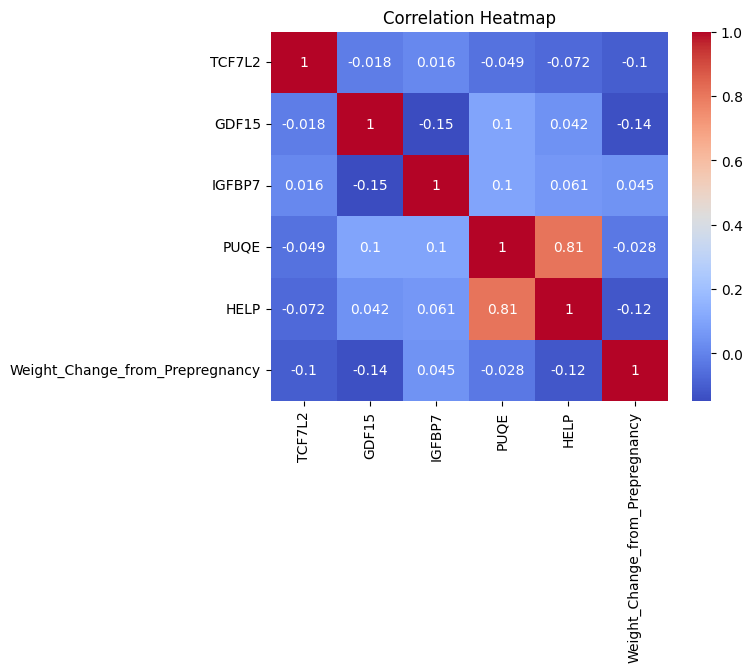

In [9]:
correlation_matrix = cleaned_visits[['TCF7L2','GDF15', 'IGFBP7', 'PUQE', 'HELP', 'Weight_Change_from_Prepregnancy']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

### Insights
* No strong correlations except between PUQE and HELP scores

## Protein Levels at First Visit vs Score
* Separate out first visit data to keep independent

In [10]:
first_visit_all = cleaned_visits[cleaned_visits['Visit_Number'] == 1]

In [11]:
def scatter_plot_with_correlation(data, x_col, y_col, severity_col, title):
    """
    Creates a scatter plot with regression lines for each severity category and computes correlations.

    Parameters:
    - data: pandas DataFrame containing the dataset
    - x_col: str, name of the column for the x-axis (protein levels)
    - y_col: str, name of the column for the y-axis (score)
    - severity_col: str, name of the column representing severity categories
    - title: str, title of the plot
    """
    # Filter out rows with missing values in the relevant columns
    filtered_data = data.dropna(subset=[x_col, y_col, severity_col])
    filtered_data = filtered_data[filtered_data[severity_col] != "Unknown"]
    
    # Initialize the scatter plot with regression lines for each severity
    sns.lmplot(
        data=filtered_data,
        x=x_col,
        y=y_col,
        hue=severity_col,
        scatter_kws={'s': 50},
        height=6,
        aspect=1.2
    )
    
    # Compute correlations for each severity category
    correlation_results = {}
    for severity in filtered_data[severity_col].unique():
        category_data = filtered_data[filtered_data[severity_col] == severity]
        x = category_data[x_col]
        y = category_data[y_col]
        
        # Calculate correlation if enough data points exist
        if len(x.dropna()) > 1 and len(y.dropna()) > 1:
            corr, p_value = pearsonr(x, y)
            correlation_results[severity] = f"r = {corr:.2f}, p = {p_value:.3f}"
    
    # Add annotations for each severity
    for severity, annotation in correlation_results.items():
        plt.gca().text(
            0.05, 
            0.95 - 0.05 * list(correlation_results.keys()).index(severity),  # Offset vertically
            f"{severity}: {annotation}",
            transform=plt.gca().transAxes,
            fontsize=10,
            ha='left',
            va='top'
        )
    
    # Set plot titles and labels
    plt.title(title, fontsize=14)
    plt.xlabel(x_col.replace("_", " "), fontsize=12)
    plt.ylabel(y_col.replace("_", " "), fontsize=12)
    plt.show()

### GDF15 vs Scores

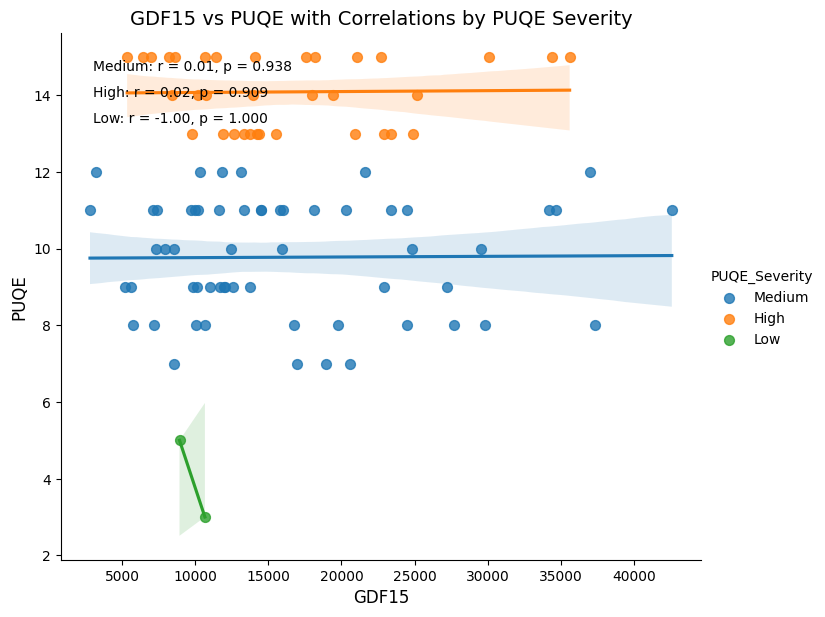

In [12]:
scatter_plot_with_correlation(
    data=first_visit_all,
    x_col='GDF15',
    y_col='PUQE',
    severity_col='PUQE_Severity',
    title="GDF15 vs PUQE with Correlations by PUQE Severity"
)

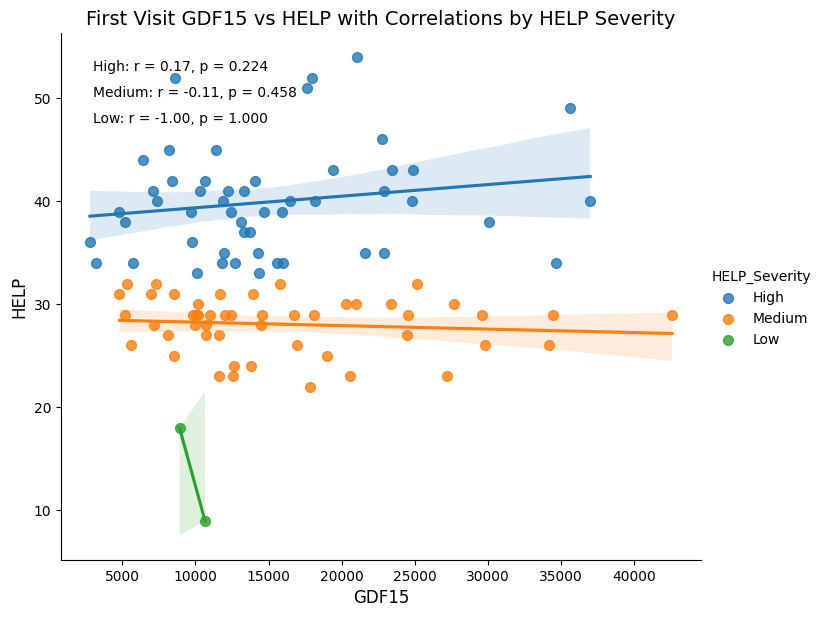

In [13]:
scatter_plot_with_correlation(
    data=first_visit_all,
    x_col='GDF15',
    y_col='HELP',
    severity_col='HELP_Severity',
    title="First Visit GDF15 vs HELP with Correlations by HELP Severity"
)

### IGFBP7 vs Scores (STATISTICALLY SIGNIFICANT MEDIUM PUQE AND HELP SEVERITY AND IGF POSITIVE CORRELATION)

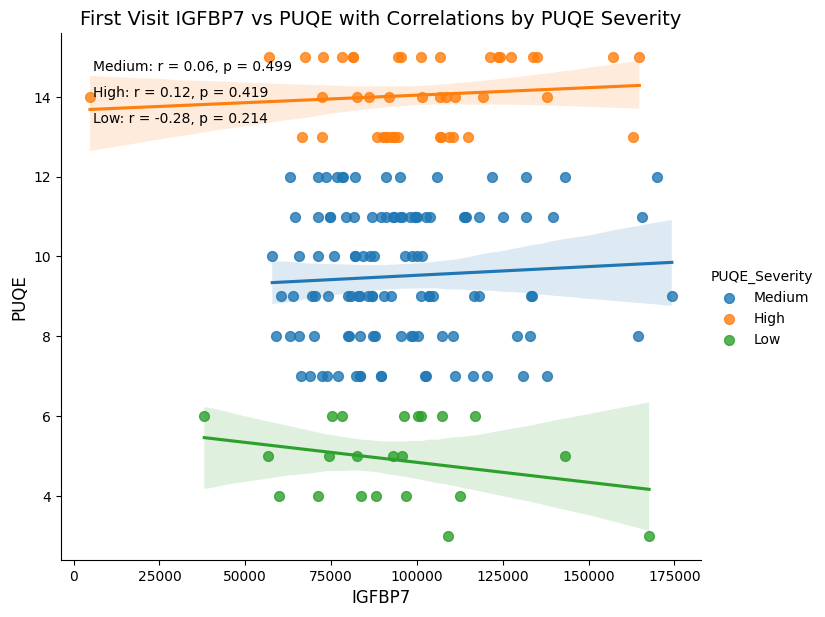

In [14]:
scatter_plot_with_correlation(
    data=cleaned_visits,
    x_col='IGFBP7',
    y_col='PUQE',
    severity_col='PUQE_Severity',
    title="First Visit IGFBP7 vs PUQE with Correlations by PUQE Severity"
)

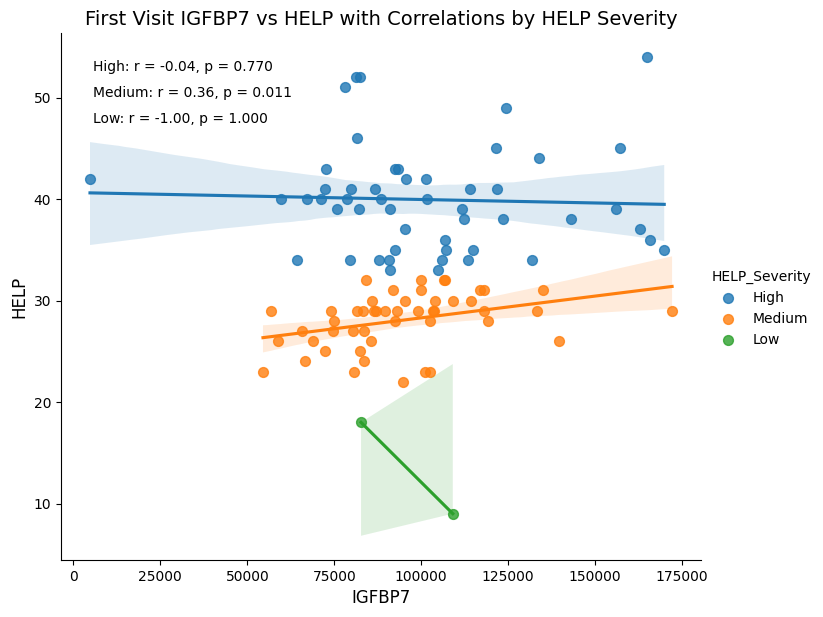

In [15]:
scatter_plot_with_correlation(
    data=first_visit_all,
    x_col='IGFBP7',
    y_col='HELP',
    severity_col='HELP_Severity',
    title="First Visit IGFBP7 vs HELP with Correlations by HELP Severity"
)

### TCF7L2 vs Scores

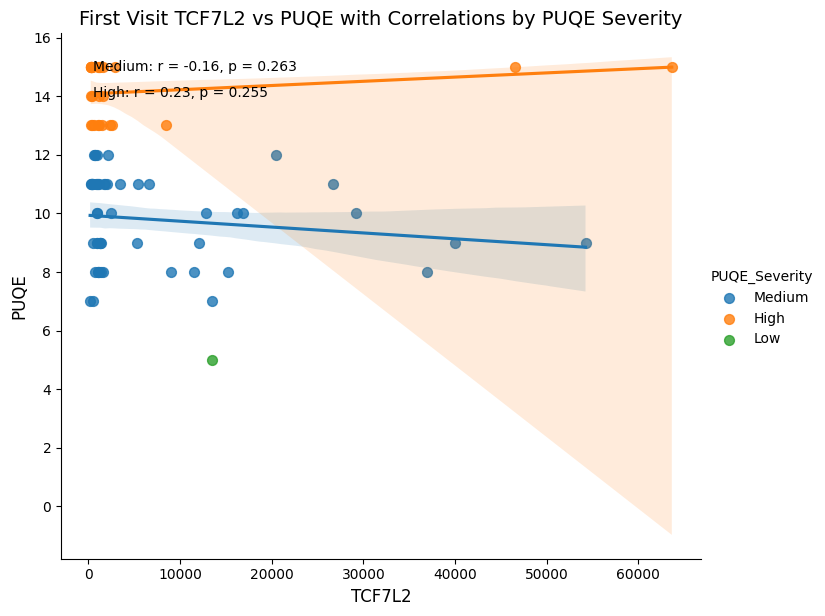

In [16]:
scatter_plot_with_correlation(
    data=first_visit_all,
    x_col='TCF7L2',
    y_col='PUQE',
    severity_col='PUQE_Severity',
    title="First Visit TCF7L2 vs PUQE with Correlations by PUQE Severity"
)

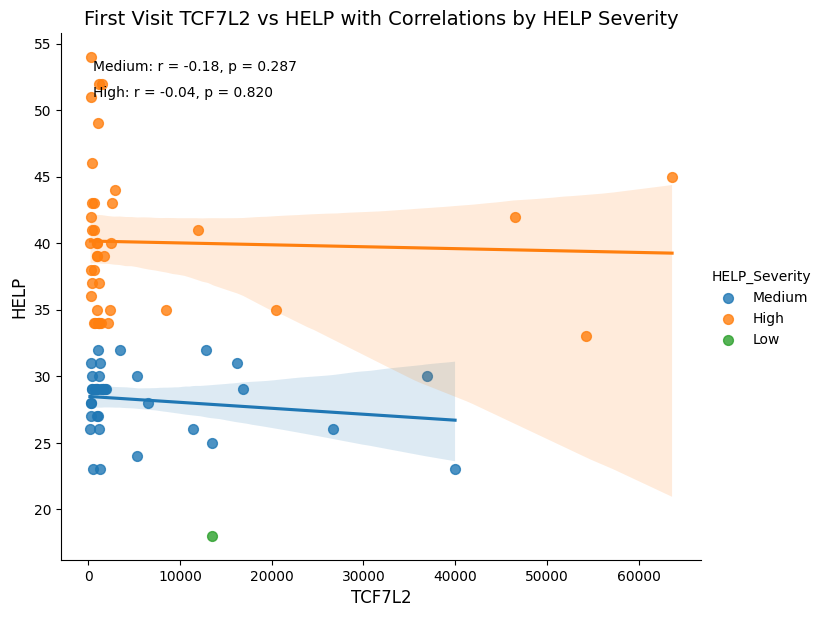

In [17]:
scatter_plot_with_correlation(
    data=first_visit_all,
    x_col='TCF7L2',
    y_col='HELP',
    severity_col='HELP_Severity',
    title="First Visit TCF7L2 vs HELP with Correlations by HELP Severity"
)

### Insights
* Statisitcally significant positive correlation between IGFBP7 and medium PUQE and HELP severity

## Protein Levels at Second Visit vs Score
* Separate out second visit data to keep independent

In [18]:
second_visit_all = cleaned_visits[cleaned_visits['Visit_Number'] == 2]

### GDF15 vs Scores (STAT SIG MEDIUM PUQE and GDF15 POSITIVE CORRELATION)

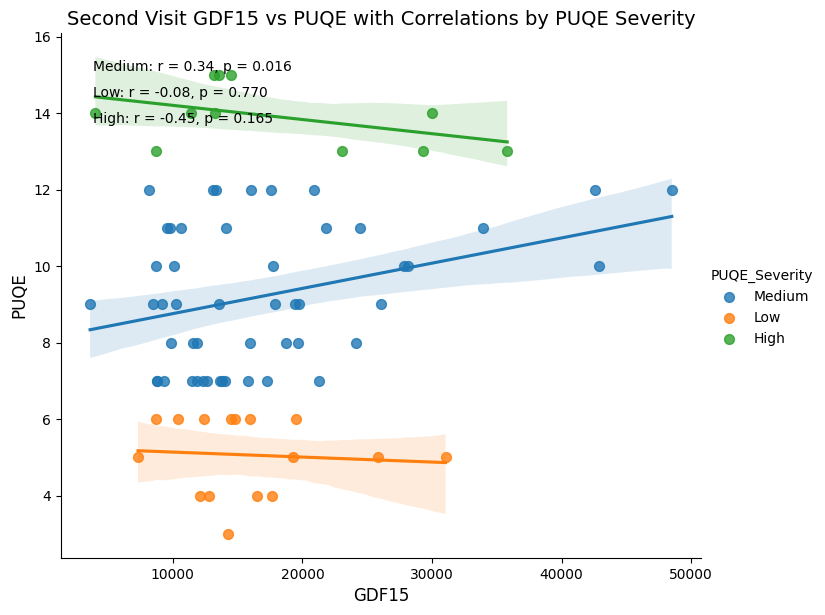

In [19]:
scatter_plot_with_correlation(
    data=second_visit_all,
    x_col='GDF15',
    y_col='PUQE',
    severity_col='PUQE_Severity',
    title="Second Visit GDF15 vs PUQE with Correlations by PUQE Severity"
)

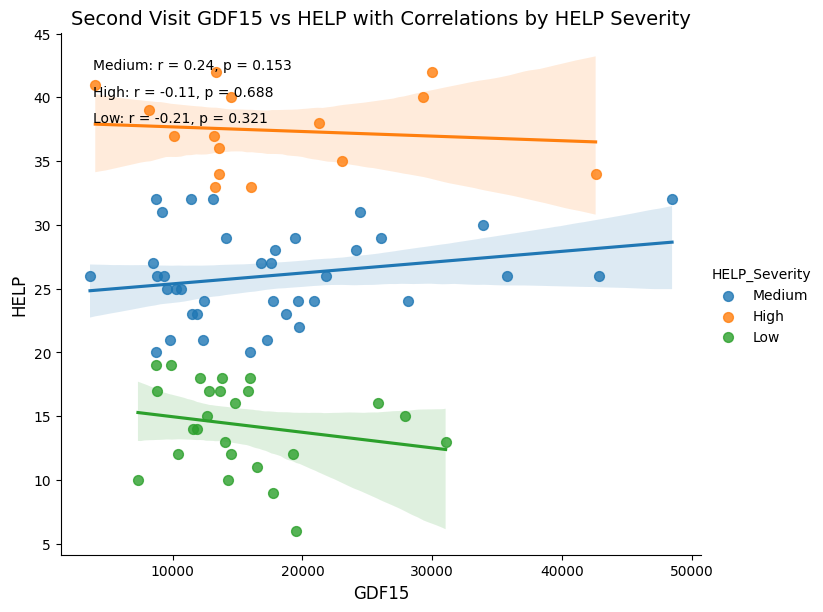

In [20]:
scatter_plot_with_correlation(
    data=second_visit_all,
    x_col='GDF15',
    y_col='HELP',
    severity_col='HELP_Severity',
    title="Second Visit GDF15 vs HELP with Correlations by HELP Severity"
)

### IGFBP7 vs Scores (STATISTICALLY SIGNIFICANT MEDIUM PUQE SEVERITY AND IGF NEGATIVE CORRELATION)

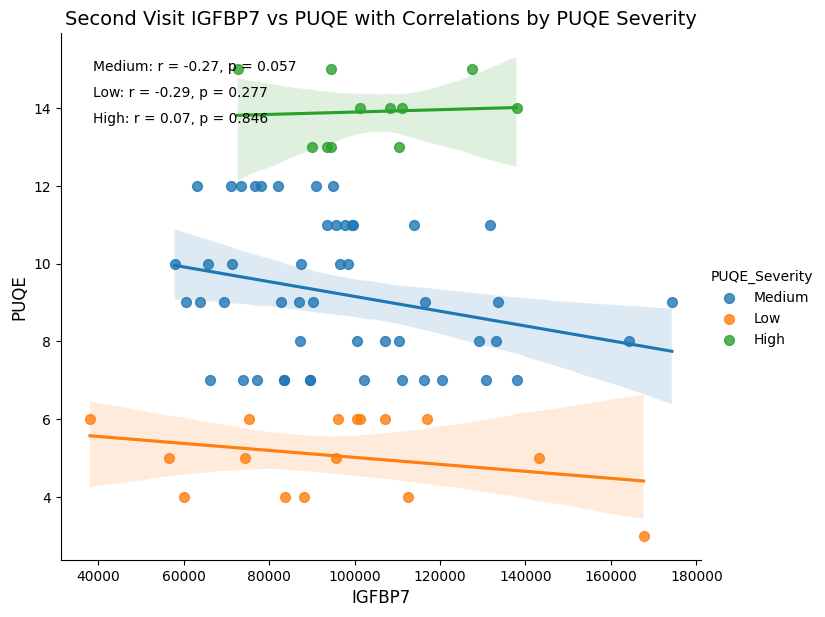

In [21]:
scatter_plot_with_correlation(
    data=second_visit_all,
    x_col='IGFBP7',
    y_col='PUQE',
    severity_col='PUQE_Severity',
    title="Second Visit IGFBP7 vs PUQE with Correlations by PUQE Severity"
)

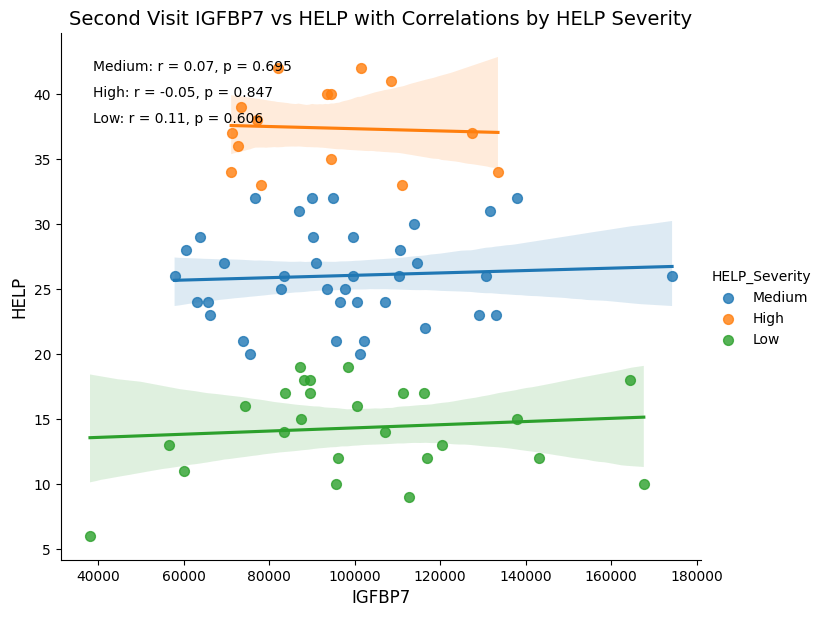

In [22]:
scatter_plot_with_correlation(
    data=second_visit_all,
    x_col='IGFBP7',
    y_col='HELP',
    severity_col='HELP_Severity',
    title="Second Visit IGFBP7 vs HELP with Correlations by HELP Severity"
)

### TCF7L2 vs Scores (STAT SIG HIGH HELP SEVERITY AND TCF)

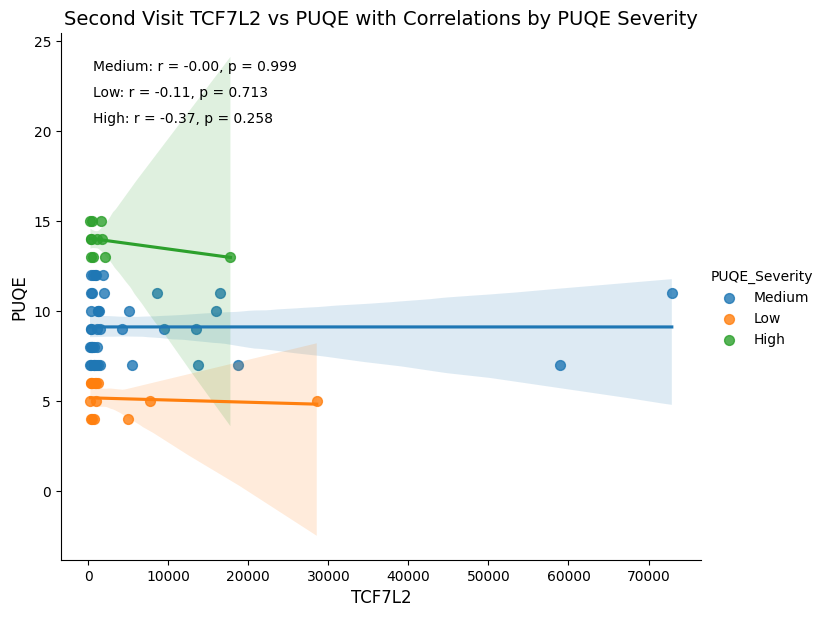

In [23]:
scatter_plot_with_correlation(
    data=second_visit_all,
    x_col='TCF7L2',
    y_col='PUQE',
    severity_col='PUQE_Severity',
    title="Second Visit TCF7L2 vs PUQE with Correlations by PUQE Severity"
)

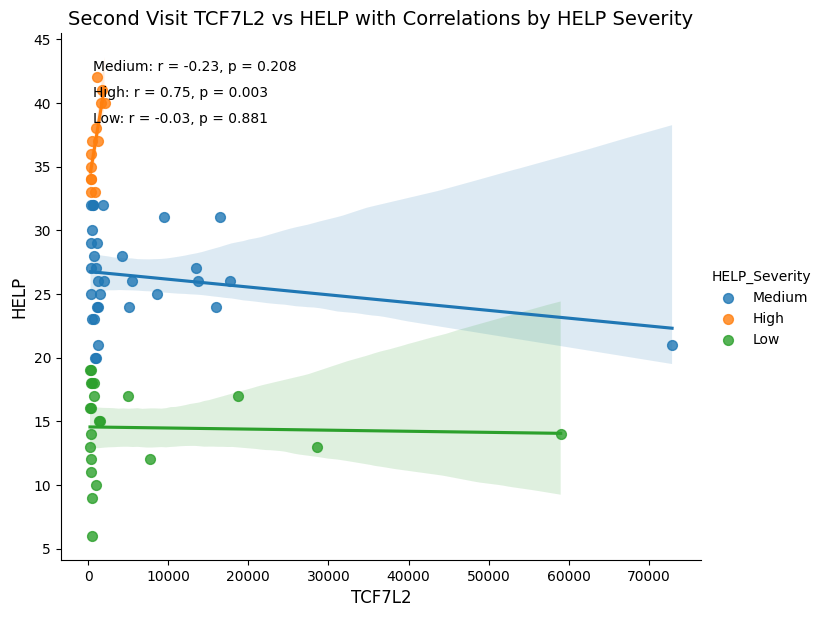

In [24]:
scatter_plot_with_correlation(
    data=second_visit_all,
    x_col='TCF7L2',
    y_col='HELP',
    severity_col='HELP_Severity',
    title="Second Visit TCF7L2 vs HELP with Correlations by HELP Severity"
)

(np.float64(0.7491829547594202), np.float64(0.0032023796914204634))

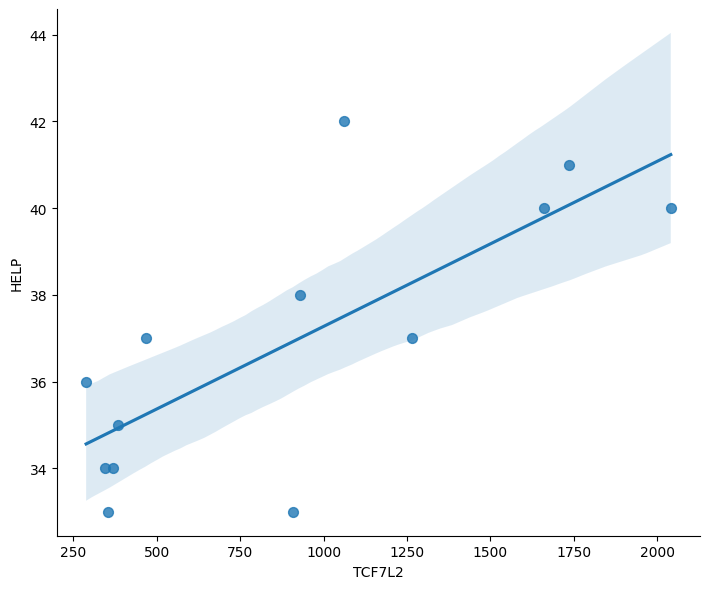

In [25]:
tcf_high_help = second_visit_all[second_visit_all['HELP_Severity'] == "High"].dropna(subset=['TCF7L2'])
sns.lmplot(
        data=tcf_high_help,
        x="TCF7L2",
        y="HELP",
        scatter_kws={'s': 50},
        height=6,
        aspect=1.2
    )
x = tcf_high_help['TCF7L2']
y = tcf_high_help['HELP']
corr, p_value = pearsonr(x, y)
corr, p_value

## First Visit Protein Levels vs Weight Change from Prepregnancy
* Use filtered data with only first visit data to keep independent

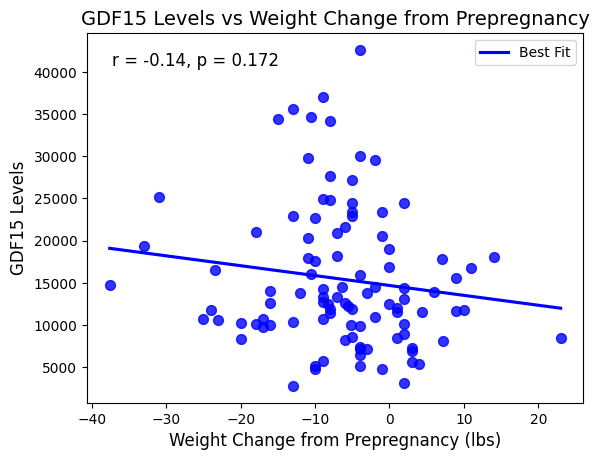

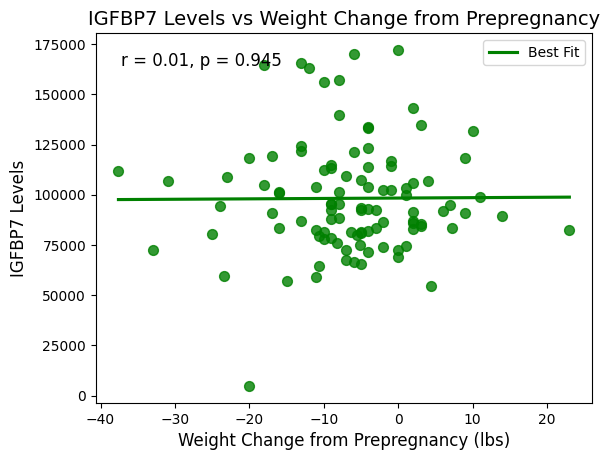

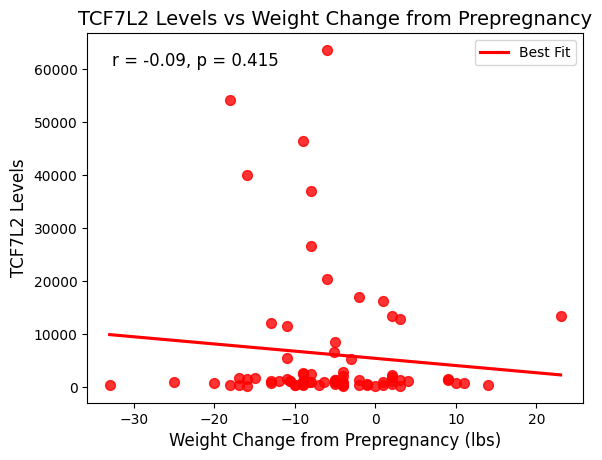

In [26]:
# Filter out missing values for weight change
filtered_weight_df = first_visit_all[first_visit_all['Weight_Change_from_Prepregnancy'].notna()]

# Filter out rows with missing protein levels
filtered_weight_gdf_df = filtered_weight_df.dropna(subset=['GDF15'])
filtered_weight_igf_df = filtered_weight_df.dropna(subset=['IGFBP7'])
filtered_weight_tcf_df = filtered_weight_df.dropna(subset=['TCF7L2'])

# Function to add scatter plot, regression line, and correlation annotations
def scatter_with_regression(data, x, y, title, xlabel, ylabel, color):
    # Create scatter plot with regression line
    sns.regplot(
        data=data, 
        x=x, 
        y=y, 
        scatter_kws={'color': color, 's': 50}, 
        line_kws={'color': color, 'label': 'Best Fit'}, 
        ci=None
    )
    
    # Calculate Pearson correlation
    x_values = data[x]
    y_values = data[y]
    if len(x_values.dropna()) > 1 and len(y_values.dropna()) > 1:
        corr, p_value = pearsonr(x_values, y_values)
        annotation = f"r = {corr:.2f}, p = {p_value:.3f}"
    else:
        annotation = "Insufficient data"
    
    # Add annotation to the plot
    plt.text(
        0.05, 0.95, annotation,
        transform=plt.gca().transAxes,
        fontsize=12,
        verticalalignment='top'
    )
    
    # Set titles and labels
    plt.title(title, fontsize=14)
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.legend(loc="best")
    plt.show()

# Plot for GDF15
scatter_with_regression(
    data=filtered_weight_gdf_df,
    x='Weight_Change_from_Prepregnancy',
    y='GDF15',
    title="GDF15 Levels vs Weight Change from Prepregnancy",
    xlabel="Weight Change from Prepregnancy (lbs)",
    ylabel="GDF15 Levels",
    color='blue'
)

# Plot for IGFBP7
scatter_with_regression(
    data=filtered_weight_igf_df,
    x='Weight_Change_from_Prepregnancy',
    y='IGFBP7',
    title="IGFBP7 Levels vs Weight Change from Prepregnancy",
    xlabel="Weight Change from Prepregnancy (lbs)",
    ylabel="IGFBP7 Levels",
    color='green'
)

# Plot for TCF7L2
scatter_with_regression(
    data=filtered_weight_tcf_df,
    x='Weight_Change_from_Prepregnancy',
    y='TCF7L2',
    title="TCF7L2 Levels vs Weight Change from Prepregnancy",
    xlabel="Weight Change from Prepregnancy (lbs)",
    ylabel="TCF7L2 Levels",
    color='red'
)

## Second Visit Protein Levels vs Weight Change from First Visit to Second
* Use filtered data with only second visit data to keep independent

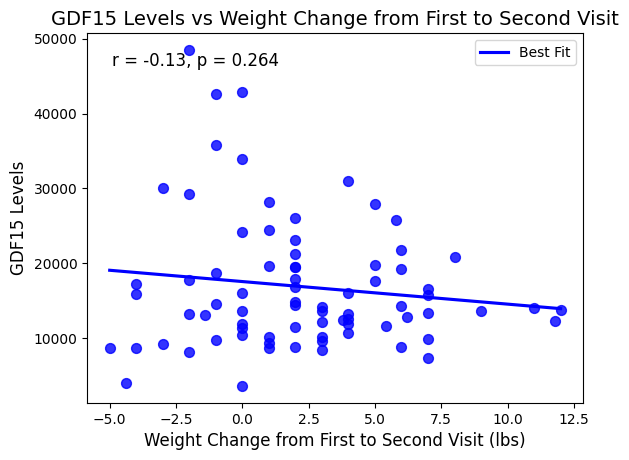

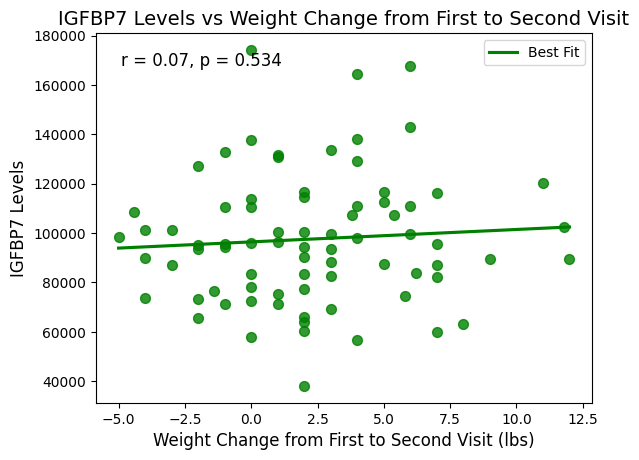

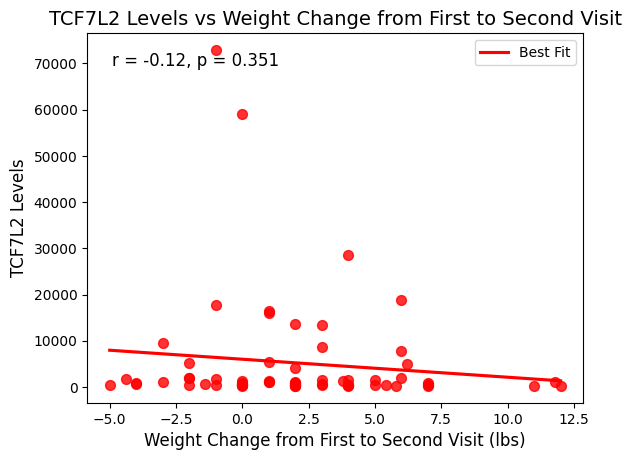

In [27]:
# Filter out missing values for weight change
filtered_weight_df_2 = second_visit_all[second_visit_all['Weight_Change_from_Last_Visit'].notna()]

# Filter out rows with missing protein levels
filtered_weight_gdf_df_2 = filtered_weight_df_2.dropna(subset=['GDF15'])
filtered_weight_igf_df_2 = filtered_weight_df_2.dropna(subset=['IGFBP7'])
filtered_weight_tcf_df_2 = filtered_weight_df_2.dropna(subset=['TCF7L2'])


# Plot for GDF15
scatter_with_regression(
    data=filtered_weight_gdf_df_2,
    x='Weight_Change_from_Last_Visit',
    y='GDF15',
    title="GDF15 Levels vs Weight Change from First to Second Visit",
    xlabel="Weight Change from First to Second Visit (lbs)",
    ylabel="GDF15 Levels",
    color='blue'
)

# Plot for IGFBP7
scatter_with_regression(
    data=filtered_weight_igf_df_2,
    x='Weight_Change_from_Last_Visit',
    y='IGFBP7',
    title="IGFBP7 Levels vs Weight Change from First to Second Visit",
    xlabel="Weight Change from First to Second Visit (lbs)",
    ylabel="IGFBP7 Levels",
    color='green'
)

# Plot for TCF7L2
scatter_with_regression(
    data=filtered_weight_tcf_df_2,
    x='Weight_Change_from_Last_Visit',
    y='TCF7L2',
    title="TCF7L2 Levels vs Weight Change from First to Second Visit",
    xlabel="Weight Change from First to Second Visit (lbs)",
    ylabel="TCF7L2 Levels",
    color='red'
)

### Insights 
Protein Levels vs HELP and PUQE scores:
* First visit:
    * statistically significant positive correlation between medium HELP severity and IGFBP7
    * statistically significant positive correlation between medium PUQE severity and IGFBP7
* Second visit:
    * statistically significant positive correlation between medium PUQE severity and GDF15
    * statistically significant negative correlation between medium HELP severity and IGFBP7
    * statistically significant positive correlation between high PUQE severity and TCF7L2 (small sample)

Protein Levels vs Weight Change from Prepregnancy & Weight Change from first to second visit:
* no statistically significant correlations

# First Visit Population Analysis
* Only look at visit 1 to keep data independent

In [28]:
# Keep only visit 1 data
visit_1_df = cleaned_visits[cleaned_visits['Visit_Number'] == 1]

In [29]:
visit_1_df.groupby('Race')[['PUQE', 'HELP', 'GDF15', 'IGFBP7']].describe()

PUQE                                                     HELP  \
       count       mean       std  min   25%   50%    75%   max count   
Race                                                                    
black   31.0  11.387097  2.603554  7.0  9.00  11.0  14.00  15.0  31.0   
latina   2.0  10.500000  3.535534  8.0  9.25  10.5  11.75  13.0   2.0   
white   56.0  11.303571  2.723097  3.0  9.00  11.0  13.25  15.0  68.0   

                   ...         GDF15               IGFBP7                 \
             mean  ...           75%           max  count           mean   
Race               ...                                                     
black   36.225806  ...  20801.747166  35611.912329   31.0  101012.624598   
latina  32.500000  ...  26506.694712  27710.309615    2.0  101252.863250   
white   32.573529  ...  18087.090000  42603.978641   69.0   96884.996263   

                                                                               \
                 std           min           25%           50%            75%   
Race                                                                            
black   31302.420091  56815.903035  78770.801559   91160.44000  119766.300310   
latina   8322.415944  95368.026500  98310.444875  101252.86325  104195.281625   
white   26307.243169   4773.312000  81962.582664   93256.28000  109069.500000   

                  
             max  
Race              
black   169852.6  
latina  107137.7  
white   172108.5  

[3 rows x 32 columns]

In [30]:
# Drop Latinx due to insufficient data 
population_df = visit_1_df[visit_1_df['Race'] != "latina"]

# Function for boxplots to analyze race and attributes
def race_boxplot(col):
    sns.boxplot(data=population_df, x='Race', y=col, palette='Set2')
    plt.title(col + " by Race")

/var/folders/83/nfh4vv717vs1mrzz_kl1vthh0000gn/T/ipykernel_3333/3532251291.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=population_df, x='Race', y=col, palette='Set2')


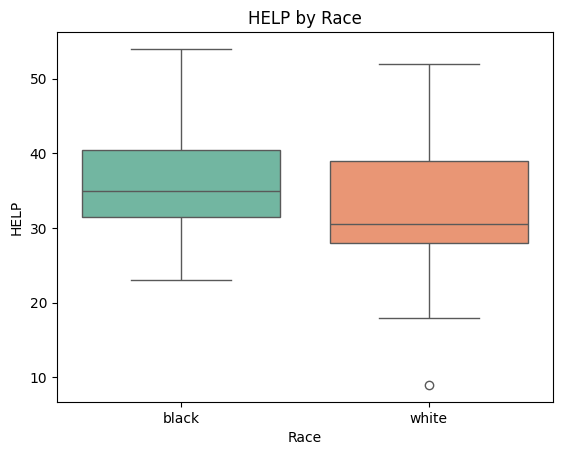

In [31]:
race_boxplot("HELP")

/var/folders/83/nfh4vv717vs1mrzz_kl1vthh0000gn/T/ipykernel_3333/3532251291.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=population_df, x='Race', y=col, palette='Set2')


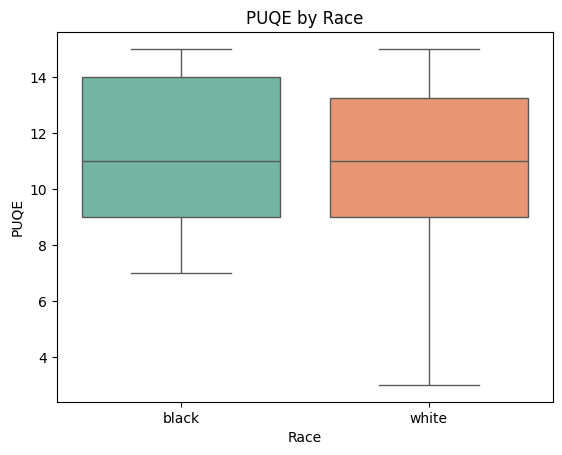

In [32]:
race_boxplot("PUQE")

/var/folders/83/nfh4vv717vs1mrzz_kl1vthh0000gn/T/ipykernel_3333/3532251291.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=population_df, x='Race', y=col, palette='Set2')


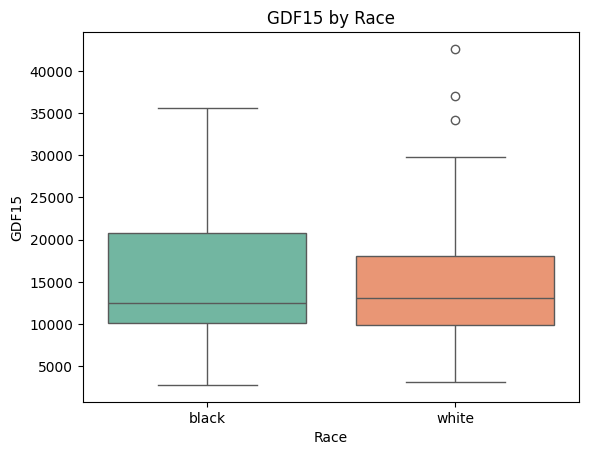

In [33]:
race_boxplot("GDF15")

/var/folders/83/nfh4vv717vs1mrzz_kl1vthh0000gn/T/ipykernel_3333/3532251291.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=population_df, x='Race', y=col, palette='Set2')


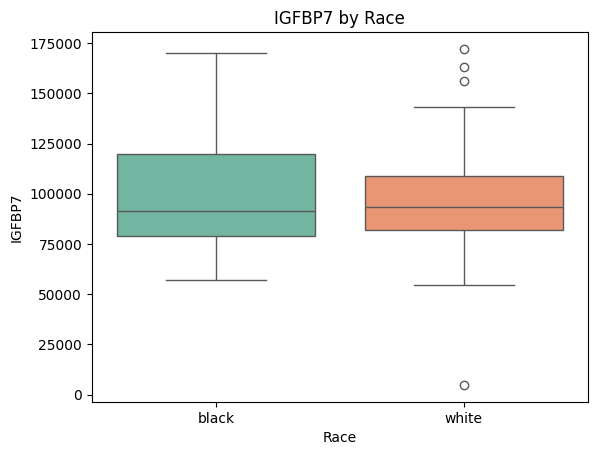

In [34]:
race_boxplot("IGFBP7")

/var/folders/83/nfh4vv717vs1mrzz_kl1vthh0000gn/T/ipykernel_3333/3532251291.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=population_df, x='Race', y=col, palette='Set2')


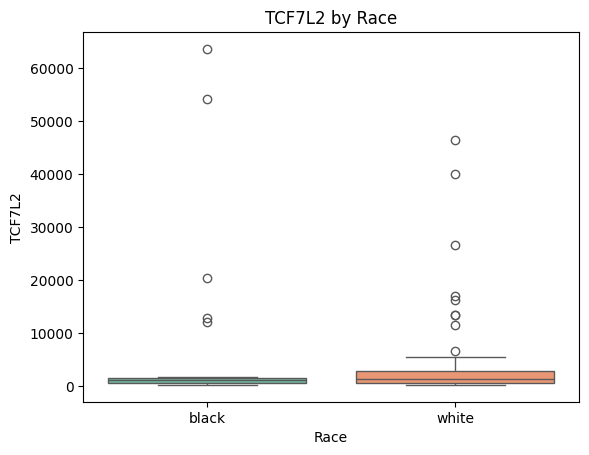

In [35]:
race_boxplot("TCF7L2")

/var/folders/83/nfh4vv717vs1mrzz_kl1vthh0000gn/T/ipykernel_3333/3532251291.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=population_df, x='Race', y=col, palette='Set2')


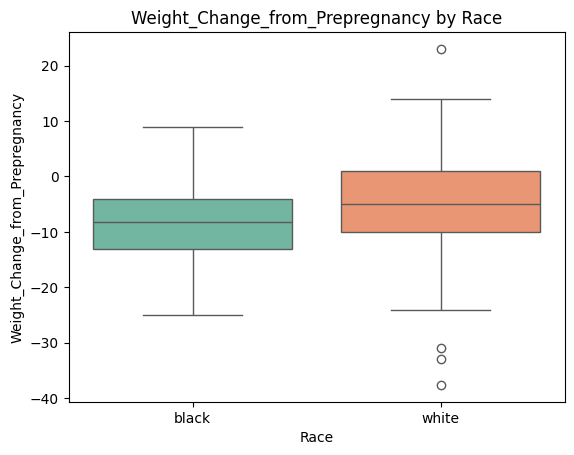

In [36]:
race_boxplot("Weight_Change_from_Prepregnancy")

/var/folders/83/nfh4vv717vs1mrzz_kl1vthh0000gn/T/ipykernel_3333/3532251291.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=population_df, x='Race', y=col, palette='Set2')


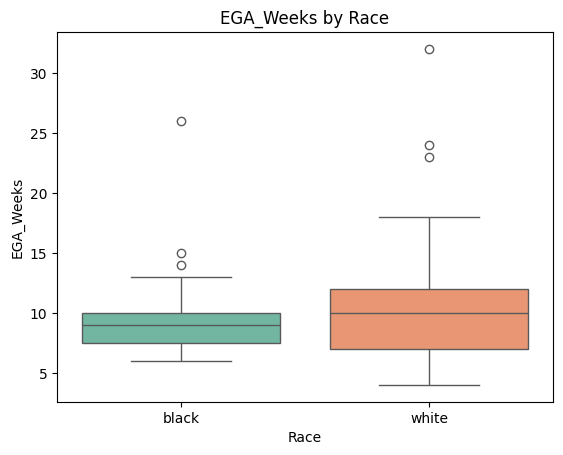

In [37]:
race_boxplot("EGA_Weeks")

### Check for statistical significance in difference between population means
* Important that only visit 1 is included here to not violate t-test assumption of independence
* Function includes test for normality, if normal, t-test is used, if not normal, Mann-Whitney U test is used

In [38]:
def perform_statistical_tests(data, group_column, value_column, group1, group2):
    """
    Perform statistical tests (normality tests and t-tests or Mann-Whitney U tests) between two groups.

    Parameters:
    - data: DataFrame containing the data.
    - group_column: Column name indicating the group (e.g., 'Race').
    - value_column: The column containing the values to test (e.g., 'IGFBP7').
    - group1: The first group to compare (e.g., 'black').
    - group2: The second group to compare (e.g., 'white').
    """
    # Filter and remove NaN values for both groups
    group1_data = data[data[group_column] == group1][value_column].dropna()
    group2_data = data[data[group_column] == group2][value_column].dropna()

    # Check the sample size
    if len(group1_data) < 3 or len(group2_data) < 3:
        print(f"Not enough data for statistical testing. {group1}: {len(group1_data)}, {group2}: {len(group2_data)}")
        return
    
    # Perform Shapiro-Wilk normality tests
    shapiro_group1 = stats.shapiro(group1_data)
    shapiro_group2 = stats.shapiro(group2_data)
    
    print(f"Shapiro-Wilk test for {group1}: p-value = {shapiro_group1.pvalue}")
    print(f"Shapiro-Wilk test for {group2}: p-value = {shapiro_group2.pvalue}")
    
    # Check if both groups are normally distributed
    if shapiro_group1.pvalue >= 0.05 and shapiro_group2.pvalue >= 0.05:
        print("Both groups are normally distributed. Performing t-tests.")
        
        # Perform Independent t-test (assuming equal variances)
        t_stat, p_value = stats.ttest_ind(group1_data, group2_data)
        print(f"Independent t-test result: t-statistic = {t_stat}, p-value = {p_value}")
        
        # Perform Welch's t-test if unequal variances are suspected
        t_stat_welch, p_value_welch = stats.ttest_ind(group1_data, group2_data, equal_var=False)
        print(f"Welch's t-test result: t-statistic = {t_stat_welch}, p-value = {p_value_welch}")
    
    else:
        print("At least one group is not normally distributed. Performing Mann-Whitney U test.")
        
        # Perform Mann-Whitney U test (non-parametric test)
        u_stat, p_value_mwu = stats.mannwhitneyu(group1_data, group2_data, alternative='two-sided')
        print(f"Mann-Whitney U test result: U-statistic = {u_stat}, p-value = {p_value_mwu}")


### First Visit HELP Scores by Race

In [39]:
perform_statistical_tests(
    data=population_df, 
    group_column='Race', 
    value_column='HELP', 
    group1='black', 
    group2='white'
)

Shapiro-Wilk test for black: p-value = 0.3886192356651123
Shapiro-Wilk test for white: p-value = 0.03348620330676659
At least one group is not normally distributed. Performing Mann-Whitney U test.
Mann-Whitney U test result: U-statistic = 1334.5, p-value = 0.03425224416387883


In [40]:
first_visit_black_help_mean = population_df[population_df['Race'] == "black"]['HELP'].mean()
first_visit_white_help_mean = population_df[population_df['Race'] == "white"]['HELP'].mean()
print("Black mean HELP score on first visit: " + str(first_visit_black_help_mean)) 
print("White mean HELP score on first visit: " + str(first_visit_white_help_mean)) 

difference_mean_help_race = first_visit_black_help_mean - first_visit_white_help_mean
print("Difference in mean HELP score on first visit between races: " + str(difference_mean_help_race)) 

Black mean HELP score on first visit: 36.225806451612904
White mean HELP score on first visit: 32.5735294117647
Difference in mean HELP score on first visit between races: 3.652277039848201


### First Visit PUQE Scores by Race

In [41]:
perform_statistical_tests(
    data=population_df, 
    group_column='Race', 
    value_column='PUQE', 
    group1='black', 
    group2='white'
)

Shapiro-Wilk test for black: p-value = 0.005863314398197046
Shapiro-Wilk test for white: p-value = 0.008817340935606205
At least one group is not normally distributed. Performing Mann-Whitney U test.
Mann-Whitney U test result: U-statistic = 861.5, p-value = 0.9571352013831402


### First Visit GDF15 Levels by Race

In [42]:
perform_statistical_tests(
    data=population_df, 
    group_column='Race', 
    value_column='GDF15', 
    group1='black', 
    group2='white'
)

Shapiro-Wilk test for black: p-value = 0.0065443934462657855
Shapiro-Wilk test for white: p-value = 0.0001373421792467125
At least one group is not normally distributed. Performing Mann-Whitney U test.
Mann-Whitney U test result: U-statistic = 1096.0, p-value = 0.8463520119783265


### First Visit IGFBP7 Levels by Race

In [43]:
perform_statistical_tests(
    data=population_df, 
    group_column='Race', 
    value_column='IGFBP7', 
    group1='black', 
    group2='white'
)

Shapiro-Wilk test for black: p-value = 0.010682600242792346
Shapiro-Wilk test for white: p-value = 0.005647680648255224
At least one group is not normally distributed. Performing Mann-Whitney U test.
Mann-Whitney U test result: U-statistic = 1080.5, p-value = 0.9376247752556


### First Visit TCF7L2 Levels by Race

In [44]:
perform_statistical_tests(
    data=population_df, 
    group_column='Race', 
    value_column='TCF7L2', 
    group1='black', 
    group2='white'
)

Shapiro-Wilk test for black: p-value = 1.0901312408629601e-08
Shapiro-Wilk test for white: p-value = 2.6921400803884143e-11
At least one group is not normally distributed. Performing Mann-Whitney U test.
Mann-Whitney U test result: U-statistic = 571.0, p-value = 0.46588574650300363


### Weight Change from Prepregnancy to First Visit by Race

In [45]:
perform_statistical_tests(
    data=population_df, 
    group_column='Race', 
    value_column='Weight_Change_from_Prepregnancy', 
    group1='black', 
    group2='white'
)

Shapiro-Wilk test for black: p-value = 0.8601389726217685
Shapiro-Wilk test for white: p-value = 0.023540911632707568
At least one group is not normally distributed. Performing Mann-Whitney U test.
Mann-Whitney U test result: U-statistic = 826.5, p-value = 0.08650755477319055


### First Visit Gestational Age in Weeks by Race

In [46]:
perform_statistical_tests(
    data=population_df, 
    group_column='Race', 
    value_column='EGA_Weeks', 
    group1='black', 
    group2='white'
)

Shapiro-Wilk test for black: p-value = 1.6755843895659234e-06
Shapiro-Wilk test for white: p-value = 1.4471826643248642e-07
At least one group is not normally distributed. Performing Mann-Whitney U test.
Mann-Whitney U test result: U-statistic = 933.0, p-value = 0.30820732736548584


### Insights
* No statistically significant difference in mean PUQE score, mean protein levels, or mean weight change from prepregnancy to first visit between black and white populations.
* Statistically significant difference in mean HELP score on first visit between black and white population, with black patients reporting a score 4 points higher on average than white patients. This may indicate increased severity in black population.

# Second Visit Population Analysis
* Only look at visit 2 to keep data independent
* Function includes test for normality, if normal, t-test is used, if not normal, Mann-Whitney U test is used

In [47]:
visit_2_df = cleaned_visits[cleaned_visits['Visit_Number'] == 2]

In [48]:
# Drop Latinx due to insufficient data 
population_df_2 = visit_2_df[visit_2_df['Race'] != "latina"]

# Function for boxplots to analyze race and attributes
def race_boxplot_2(col):
    sns.boxplot(data=population_df_2, x='Race', y=col, palette='Set2')
    plt.title(col + " by Race")

/var/folders/83/nfh4vv717vs1mrzz_kl1vthh0000gn/T/ipykernel_3333/4255830166.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=population_df_2, x='Race', y=col, palette='Set2')


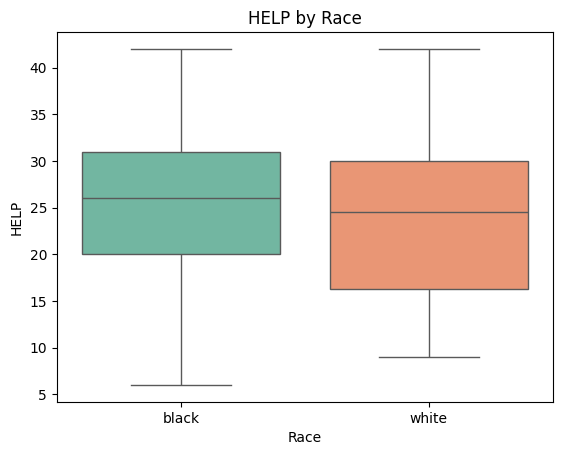

In [49]:
race_boxplot_2('HELP')

/var/folders/83/nfh4vv717vs1mrzz_kl1vthh0000gn/T/ipykernel_3333/4255830166.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=population_df_2, x='Race', y=col, palette='Set2')


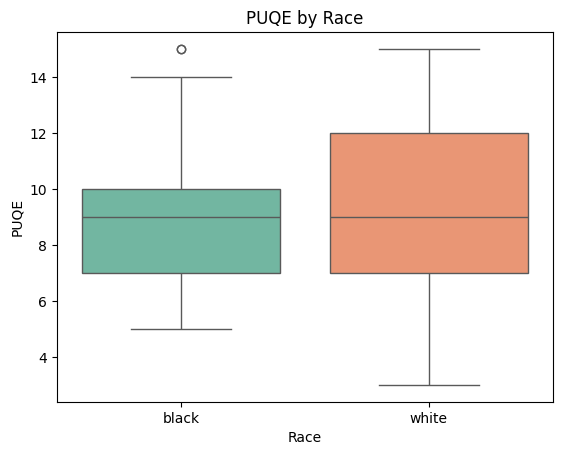

In [50]:
race_boxplot_2('PUQE')

/var/folders/83/nfh4vv717vs1mrzz_kl1vthh0000gn/T/ipykernel_3333/4255830166.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=population_df_2, x='Race', y=col, palette='Set2')


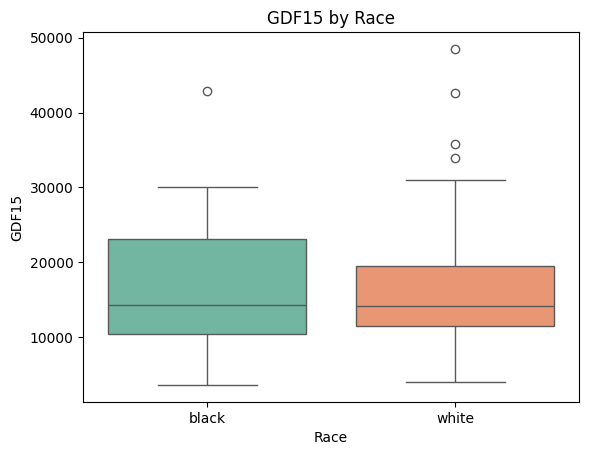

In [51]:
race_boxplot_2('GDF15')

/var/folders/83/nfh4vv717vs1mrzz_kl1vthh0000gn/T/ipykernel_3333/4255830166.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=population_df_2, x='Race', y=col, palette='Set2')


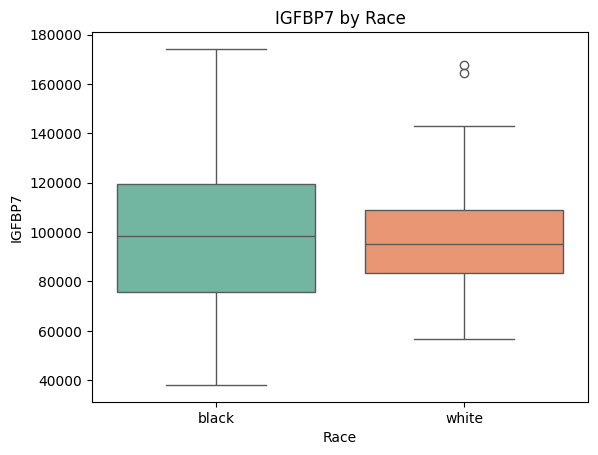

In [52]:
race_boxplot_2('IGFBP7')

/var/folders/83/nfh4vv717vs1mrzz_kl1vthh0000gn/T/ipykernel_3333/4255830166.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=population_df_2, x='Race', y=col, palette='Set2')


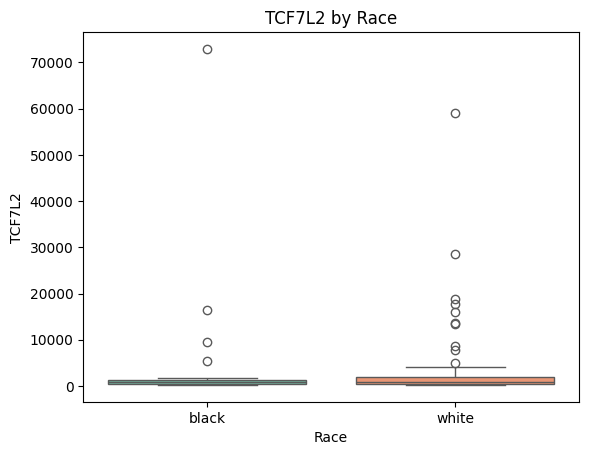

In [53]:
race_boxplot_2('TCF7L2')

/var/folders/83/nfh4vv717vs1mrzz_kl1vthh0000gn/T/ipykernel_3333/4255830166.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=population_df_2, x='Race', y=col, palette='Set2')


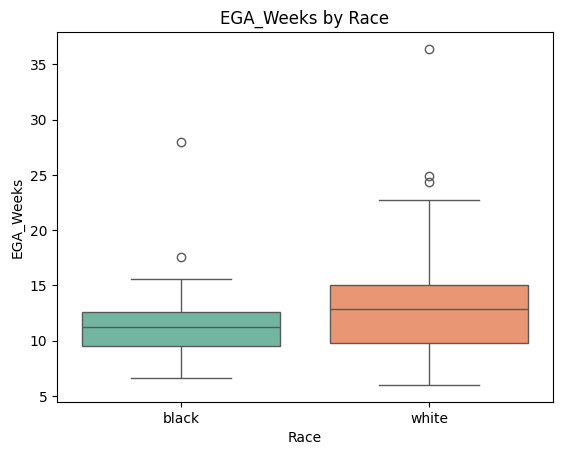

In [54]:
race_boxplot_2('EGA_Weeks')

/var/folders/83/nfh4vv717vs1mrzz_kl1vthh0000gn/T/ipykernel_3333/4255830166.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=population_df_2, x='Race', y=col, palette='Set2')


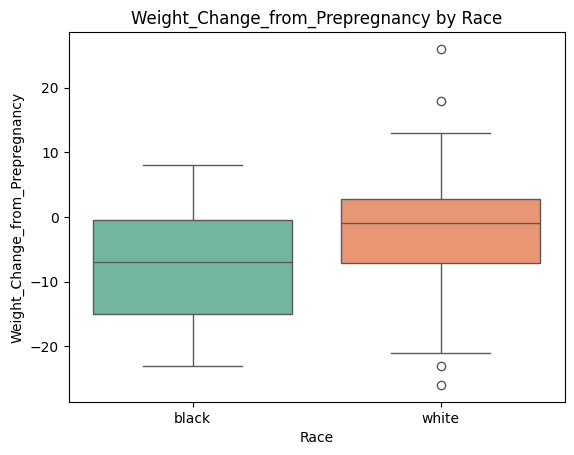

In [55]:
race_boxplot_2('Weight_Change_from_Prepregnancy')

/var/folders/83/nfh4vv717vs1mrzz_kl1vthh0000gn/T/ipykernel_3333/4255830166.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=population_df_2, x='Race', y=col, palette='Set2')


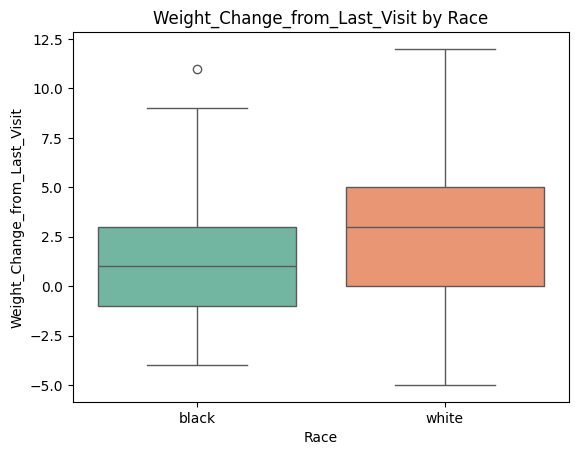

In [56]:
race_boxplot_2('Weight_Change_from_Last_Visit')

### Check for statistical significance in difference between population means
* Important that only visit 2 is included here to not violate t-test assumption of independence

#### Second Visit HELP scores by Race

In [57]:
perform_statistical_tests(
    data=population_df_2, 
    group_column='Race', 
    value_column='HELP', 
    group1='black', 
    group2='white'
)

Shapiro-Wilk test for black: p-value = 0.9727421204832073
Shapiro-Wilk test for white: p-value = 0.11156618148147684
Both groups are normally distributed. Performing t-tests.
Independent t-test result: t-statistic = 0.7069133905558187, p-value = 0.4817541726895289
Welch's t-test result: t-statistic = 0.7137000014610292, p-value = 0.4788731502190633


#### Second Visit PUQE scores by Race

In [58]:
perform_statistical_tests(
    data=population_df_2, 
    group_column='Race', 
    value_column='PUQE', 
    group1='black', 
    group2='white'
)

Shapiro-Wilk test for black: p-value = 0.03184490938642813
Shapiro-Wilk test for white: p-value = 0.062331051008650995
At least one group is not normally distributed. Performing Mann-Whitney U test.
Mann-Whitney U test result: U-statistic = 657.0, p-value = 0.9570763321423383


#### Second Visit GDF15 levels by Race

In [59]:
perform_statistical_tests(
    data=population_df_2, 
    group_column='Race', 
    value_column='GDF15', 
    group1='black', 
    group2='white'
)

Shapiro-Wilk test for black: p-value = 0.025269400338821905
Shapiro-Wilk test for white: p-value = 1.2153907347272808e-05
At least one group is not normally distributed. Performing Mann-Whitney U test.
Mann-Whitney U test result: U-statistic = 696.0, p-value = 0.8362505262545823


#### Second Visit IGFBP7 levels by Race

In [60]:
perform_statistical_tests(
    data=population_df_2, 
    group_column='Race', 
    value_column='IGFBP7', 
    group1='black', 
    group2='white'
)

Shapiro-Wilk test for black: p-value = 0.8848692333834163
Shapiro-Wilk test for white: p-value = 0.011701596552211892
At least one group is not normally distributed. Performing Mann-Whitney U test.
Mann-Whitney U test result: U-statistic = 715.0, p-value = 0.6832063967038339


#### Second Visit TCF7L2 levels by Race

In [61]:
perform_statistical_tests(
    data=population_df_2, 
    group_column='Race', 
    value_column='TCF7L2', 
    group1='black', 
    group2='white'
)

Shapiro-Wilk test for black: p-value = 1.4173878414508818e-08
Shapiro-Wilk test for white: p-value = 2.991115969390949e-11
At least one group is not normally distributed. Performing Mann-Whitney U test.
Mann-Whitney U test result: U-statistic = 456.0, p-value = 0.8256601133882692


#### Second Visit Gestational Age in Weeks by Race

In [62]:
perform_statistical_tests(
    data=population_df_2, 
    group_column='Race', 
    value_column='EGA_Weeks', 
    group1='black', 
    group2='white'
)

Shapiro-Wilk test for black: p-value = 0.00012689578428299916
Shapiro-Wilk test for white: p-value = 1.2210545860476098e-05
At least one group is not normally distributed. Performing Mann-Whitney U test.
Mann-Whitney U test result: U-statistic = 585.5, p-value = 0.2333088575797363


#### Second Visit Weight Change from Prepregnancy by Race

In [63]:
perform_statistical_tests(
    data=population_df_2, 
    group_column='Race', 
    value_column='Weight_Change_from_Prepregnancy', 
    group1='black', 
    group2='white'
)

Shapiro-Wilk test for black: p-value = 0.6397768317532442
Shapiro-Wilk test for white: p-value = 0.30404030340517807
Both groups are normally distributed. Performing t-tests.
Independent t-test result: t-statistic = -1.8247902140195078, p-value = 0.07191126917415369
Welch's t-test result: t-statistic = -1.9100035039189245, p-value = 0.061600857394797356


#### Second Visit Weight Change from First Visit by Race

In [64]:
perform_statistical_tests(
    data=population_df_2, 
    group_column='Race', 
    value_column='Weight_Change_from_Last_Visit', 
    group1='black', 
    group2='white'
)

Shapiro-Wilk test for black: p-value = 0.08031886376056456
Shapiro-Wilk test for white: p-value = 0.5236004883137557
Both groups are normally distributed. Performing t-tests.
Independent t-test result: t-statistic = -1.0916625351791487, p-value = 0.2784301524190419
Welch's t-test result: t-statistic = -1.078743380989312, p-value = 0.286354720358294


### Insights
* No statistically significant difference in mean HELP, PUQE, protein levels, EGA, or weight change for second visit data
* The second visit weight change from prepregnancy by race is marginally significant with a p-value just above the 0.05 threshold ~0.06.

# TCF7L2 Analysis
* Build TCF7L2 summary dataframe
* Analyze differences based on high and low levels of TCF7L2 separated at median
* Analyze differences based on high and low levels of TCF7L2 separated at top quartile
* Analyze differences based on high and low levels of TCF7L2 separated at bottom quartile


### Filter Data
* Keep patients who had TCF7L2 levels recorded (unique patients = 82)
* Create df with only first visits (unique patients = 82)
* Create df with only those that had a first and second visit (unique patients = 66)

In [65]:
# Keep patients with TCF7L2 levels recorded
tcf7l2_cleaned = cleaned_visits[~cleaned_visits['TCF7L2'].isna()]

# Keep patients with first visit
tcf7l2_first_visit = tcf7l2_cleaned[tcf7l2_cleaned['Visit_Number'] == 1]

# Identify IDs with both first and second visits
valid_ids = tcf7l2_cleaned.groupby('ID')['Visit_Number'].apply(lambda x: {1, 2}.issubset(set(x)))

# Filter for IDs that have both visits
valid_ids = valid_ids[valid_ids].index  # Extract IDs that meet the condition

# Subset the DataFrame
tcf_with_2nd_visit = tcf7l2_cleaned[tcf7l2_cleaned['ID'].isin(valid_ids)]

### Race Composition
* Based on first visit for independence, assuming those with a second visit had a first visit
* Since some race data is missing, n=77

In [66]:
# Find race composition based on unique IDs
black_composition_tcf = round((len(tcf7l2_first_visit[tcf7l2_first_visit['Race'] == "black"])/len(tcf7l2_first_visit))*100,2)
white_composition_tcf = round((len(tcf7l2_first_visit[tcf7l2_first_visit['Race'] == "white"])/len(tcf7l2_first_visit))*100,2)
latina_composition_tcf = round((len(tcf7l2_first_visit[tcf7l2_first_visit['Race'] == "latina"])/len(tcf7l2_first_visit))*100,2)
black_composition_tcf, white_composition_tcf, latina_composition_tcf

black_n_tcf = len(tcf7l2_first_visit[tcf7l2_first_visit['Race'] == "black"])
white_n_tcf = len(tcf7l2_first_visit[tcf7l2_first_visit['Race'] == "white"])
latina_n_tcf = len(tcf7l2_first_visit[tcf7l2_first_visit['Race'] == "latina"])

# Create df with race composition 
d = {'Race': ["black", "white", "latina"], 'Composition (%)': [black_composition_tcf, white_composition_tcf, latina_composition_tcf], 
    'Sample Size (n)': [black_n_tcf, white_n_tcf, latina_n_tcf]}
race_comp_tcf = pd.DataFrame(data=d)

race_comp_tcf

# Export as excel
# race_comp_tcf.to_excel('tcf_race_composition_1.19.25.xlsx', index=False)

,Race,Composition (%),Sample Size (n)
0,black,31.71,26
1,white,59.76,49
2,latina,2.44,2


### Summarize 1st and 2nd Visit data for TCF7L2

In [67]:
# Filter the data for 1st and 2nd visits including subset with only first visits for those that also have second visits
first_visit = tcf7l2_first_visit
second_visit = tcf_with_2nd_visit[tcf_with_2nd_visit['Visit_Number'] == 2]
first_visit_with_second = tcf_with_2nd_visit[tcf_with_2nd_visit['Visit_Number'] == 1]


# Create a dictionary to calculate metrics
results = {
    "EGA_Weeks_1st_Visit": first_visit['EGA_Weeks'],
    "EGA_Weeks_2nd_Visit": second_visit['EGA_Weeks'],
    "HELP_1st_Visit": first_visit['HELP'],
    "PUQE_1st_Visit": first_visit['PUQE'],
    "Prepregnancy_Weight": first_visit['Prepregnancy_Weight'],
    "Weight_1st_Visit": first_visit['Current_Weight'],
    "Weight_Change_Prepreg_to_1st": first_visit['Weight_Change_from_Prepregnancy'],
    # "Weight_Difference_Prepreg_to_1st (%)": (first_visit['Current_Weight'] - first_visit['Prepregnancy_Weight'])/first_visit['Prepregnancy_Weight']* 100,
    # "2nd lab draw": second_visit['Visit_Number'],  # Placeholder
    "HELP_2nd_Visit": second_visit['HELP'],
    "PUQE_2nd_Visit": second_visit['PUQE'],
    "Weight_2nd_Visit": second_visit['Current_Weight'],
    "Weight_Change_1st_to_2nd": second_visit["Weight_Change_from_Last_Visit"],
    # "Weight_Difference_1st_to_2nd (%)": (second_visit["Weight_Change_from_Last_Visit"] / first_visit_with_second["Current_Weight"].values) * 100,
    "TCF7L2_1st_Visit": first_visit['TCF7L2'],
    "TCF7L2_2nd_Visit": second_visit['TCF7L2']
}

# Initialize an empty list to store the summary data
summary_data = []

# Calculate average, median, range, min, and max for each metric
for metric, values in results.items():
    avg = values.mean() if pd.api.types.is_numeric_dtype(values) else "N/A"
    median = values.median() if pd.api.types.is_numeric_dtype(values) else "N/A"
    rng = values.max() - values.min() if pd.api.types.is_numeric_dtype(values) else "N/A"
    min = values.min() if pd.api.types.is_numeric_dtype(values) else "N/A"
    max = values.max() if pd.api.types.is_numeric_dtype(values) else "N/A"
    summary_data.append({
        "Metric": metric,
        "Average": avg,
        "Median": median,
        "Range": rng,
        "Min": min,
        "Max": max
    })

# Convert the list to a DataFrame
tcf_summary_table = pd.DataFrame(summary_data)

# Display the summary table
tcf_summary_table

# Export as xlsx
# tcf_summary_table.to_excel('tcf_summary_table_1.22.25.xlsx', index=False)

,Metric,Average,Median,Range,Min,Max
0,EGA_Weeks_1st_Visit,10.602597,9.0000,28.000,4.000,32.00
1,EGA_Weeks_2nd_Visit,13.143939,11.9500,30.400,6.000,36.40
2,HELP_1st_Visit,34.166667,33.5000,36.000,18.000,54.00
3,PUQE_1st_Visit,11.135802,11.0000,10.000,5.000,15.00
4,Prepregnancy_Weight,175.893827,165.0000,188.000,102.000,290.00
5,Weight_1st_Visit,170.000000,159.0000,179.000,100.000,279.00
6,Weight_Change_Prepreg_to_1st,-5.697368,-5.6000,56.000,-33.000,23.00
7,HELP_2nd_Visit,24.378788,25.0000,36.000,6.000,42.00
8,PUQE_2nd_Visit,9.076923,9.0000,11.000,4.000,15.00
9,Weight_2nd_Visit,172.372727,161.5000,182.800,102.000,284.80


### Check for significant differences between low and high TCF7L2 levels separated at the median
* Using only rows with TCF7L2 data
* Using only rows with non null values
* Filter for first and second visits
* Split data into high and low TCF7L2 levels at the median
* Calculate median EGA, HELP, PUQE, Prepregnancy Weight, Visit Weight, Weight Change from Prepregnancy, Weight Change from Last Visit for high and low TCF7L2 groups
* Test if there is a statistically signficant difference between the medians
    * Check that data is approx normal and has similar variance to meet assumptions of indepedent t-test otherwise use Mann-Whitney U test

In [68]:
# Filter the data for 1st and 2nd visits including subset with only first visits for those that also have second visits
first_visit = tcf7l2_first_visit
second_visit = tcf_with_2nd_visit[tcf_with_2nd_visit['Visit_Number'] == 2]
first_visit_with_second = tcf_with_2nd_visit[tcf_with_2nd_visit['Visit_Number'] == 1]

# Split the second visit data into High and Low TCF7L2 based on the median of TCF7L2
median_tcf_first = first_visit['TCF7L2'].median()
median_tcf_second = second_visit['TCF7L2'].median()

first_visit['TCF_Group'] = ['High' if x > median_tcf_first else 'Low' for x in first_visit['TCF7L2']]
second_visit['TCF_Group'] = ['High' if x > median_tcf_second else 'Low' for x in second_visit['TCF7L2']]

# Define the metrics we want to analyze
metrics_to_analyze = [
    "EGA_Weeks", "HELP", "PUQE", "Prepregnancy_Weight", "Current_Weight", 
    "Weight_Change_from_Prepregnancy", "Weight_Change_from_Last_Visit", 
    "TCF7L2"
]

# Initialize an empty list to store the summary data
summary_data = []

# Function to calculate median and perform normality check
def calculate_summary(data, metric):
    high_values = data[data['TCF_Group'] == 'High'][metric].dropna()
    low_values = data[data['TCF_Group'] == 'Low'][metric].dropna()
    
    # Skip normality test if either group has fewer than 3 values
    if len(high_values) < 3 or len(low_values) < 3:
        test_used = "Not enough data for normality test"
        p_value = None
        significant = "Insufficient data"
        median_high = high_values.median() if len(high_values) > 0 else "N/A"
        median_low = low_values.median() if len(low_values) > 0 else "N/A"
        sample_size_high = len(high_values)
        sample_size_low = len(low_values)
        return median_high, median_low, significant, test_used, sample_size_high, sample_size_low
    
    # Check normality
    normal_high = shapiro(high_values)[1] >= 0.05
    normal_low = shapiro(low_values)[1] >= 0.05
    
    # Determine which test to use
    if normal_high and normal_low:
        # Use t-test if both groups are normal
        t_stat, p_value = ttest_ind(high_values, low_values, nan_policy='omit')
        test_used = "t-test"
    else:
        # Use Mann-Whitney U test if not normal
        t_stat, p_value = mannwhitneyu(high_values, low_values, alternative='two-sided')
        test_used = "Mann-Whitney U"

    # Calculate medians
    median_high = high_values.median()
    median_low = low_values.median()
    
    # Sample sizes
    sample_size_high = len(high_values)
    sample_size_low = len(low_values)
    
    # Check if the difference is significant
    significant = "Yes" if p_value < 0.05 else "No"
    
    return median_high, median_low, significant, test_used, sample_size_high, sample_size_low

# Perform the analysis for each metric
for metric in metrics_to_analyze:
    # For first visit
    median_high_first, median_low_first, significant_first, test_used_first, sample_size_high_first, sample_size_low_first = calculate_summary(first_visit, metric)
    
    # For second visit
    median_high_second, median_low_second, significant_second, test_used_second, sample_size_high_second, sample_size_low_second = calculate_summary(second_visit, metric)

    # Add the results to the summary data list
    summary_data.append({
        "Metric": f"{metric} - 1st Visit High vs Low TCF7L2", 
        "Median (High)": median_high_first, 
        "Median (Low)": median_low_first,
        "Significant Difference (p < 0.05)": significant_first,
        "Test Used": test_used_first,
        "Sample Size (High)": sample_size_high_first,
        "Sample Size (Low)": sample_size_low_first
    })
    
    summary_data.append({
        "Metric": f"{metric} - 2nd Visit High vs Low TCF7L2", 
        "Median (High)": median_high_second, 
        "Median (Low)": median_low_second,
        "Significant Difference (p < 0.05)": significant_second,
        "Test Used": test_used_second,
        "Sample Size (High)": sample_size_high_second,
        "Sample Size (Low)": sample_size_low_second
    })

# Convert the list of dictionaries into a DataFrame
summary_table = pd.DataFrame(summary_data)

# Display the updated summary table
summary_table
# summary_table.to_excel('tcf_high_low_median_table_1.22.25.xlsx', index=False)


/var/folders/83/nfh4vv717vs1mrzz_kl1vthh0000gn/T/ipykernel_3333/1945480378.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  first_visit['TCF_Group'] = ['High' if x > median_tcf_first else 'Low' for x in first_visit['TCF7L2']]
/var/folders/83/nfh4vv717vs1mrzz_kl1vthh0000gn/T/ipykernel_3333/1945480378.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_visit['TCF_Group'] = ['High' if x > median_tcf_second else 'Low' for x in second_visit['TCF7L2']]


,Metric,Median (High),Median (Low),Significant Difference (p < 0.05),Test Used,Sample Size (High),Sample Size (Low)
0,EGA_Weeks - 1st Visit High vs Low TCF7L2,9.0,9.5,No,Mann-Whitney U,37,40
1,EGA_Weeks - 2nd Visit High vs Low TCF7L2,11.9,12.1,No,Mann-Whitney U,33,33
2,HELP - 1st Visit High vs Low TCF7L2,31.0,34.0,No,t-test,37,41
3,HELP - 2nd Visit High vs Low TCF7L2,26.0,23.0,No,t-test,33,33
4,PUQE - 1st Visit High vs Low TCF7L2,10.0,11.5,No,Mann-Whitney U,41,40
5,PUQE - 2nd Visit High vs Low TCF7L2,9.0,8.0,No,Mann-Whitney U,33,32
6,Prepregnancy_Weight - 1st Visit High vs Low TC...,169.0,164.0,No,Mann-Whitney U,41,40
7,Prepregnancy_Weight - 2nd Visit High vs Low TC...,185.0,155.0,Yes,Mann-Whitney U,33,33
8,Current_Weight - 1st Visit High vs Low TCF7L2,171.5,154.0,No,Mann-Whitney U,36,41
9,Current_Weight - 2nd Visit High vs Low TCF7L2,173.0,155.0,Yes,Mann-Whitney U,33,33


### Insights
* Significant difference between the 2nd visit weight for high and low levels of TCF7L2
* Significant difference between the 2nd visit prepregnancy weight for high and low levels of TCF7L2, however not a significant difference in prepregnancy weight for 1st visit prepregnancy weight.
* The significant difference observed only among patients with a second visit may indicate a potentially more severe subgroup of HG patients, as their need for a follow-up suggests greater clinical concern or symptom severity.
    * The significant difference in median prepregnancy and current weight between high and low TCF7L2 levels in the second visit group suggests that patients with lower TCF7L2 levels may be exhibiting characteristics associated with more severe or prolonged cases of HG. Since individuals with lower TCF7L2 levels have a lower median prepregnancy and current weight, this could indicate a potential link between TCF7L2 levels and the severity of HG symptoms in this subset of patients.
 
1. Second Visit Weight and Prepregnancy Weight (Median Split):
    * The second visit shows significant differences in Weight and Prepregnancy Weight between high and low TCF7L2 levels when split by the median.
    * The first visit prepregnancy weight, however, did not show any significant differences. This may suggest that prepregnancy weight at the time of the second visit could reflect more about the TCF7L2 levels than at the time of the first visit.

### Second Visit - Prepregnancy Weight by TCF7L2 Levels

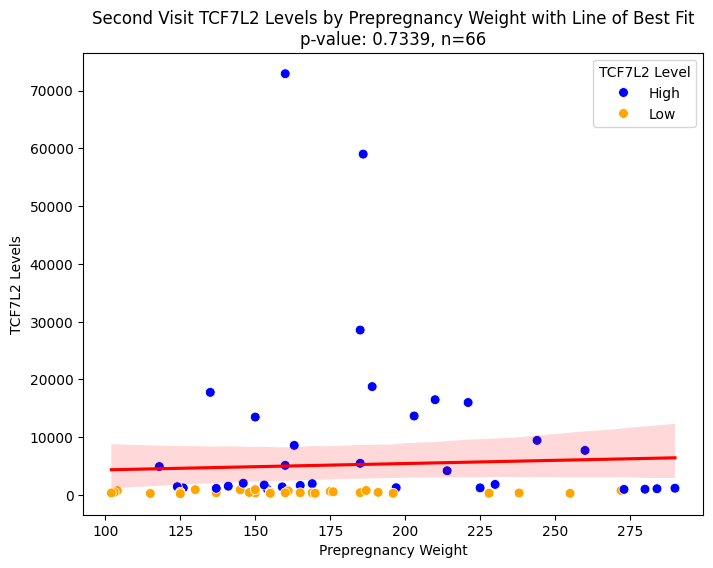

In [69]:
plt.figure(figsize=(8, 6))

# Drop rows where Prepregnancy Weight or the TCF7L2 protein level is NaN
second_visit_prepreg_tcf = second_visit.dropna(subset=['Prepregnancy_Weight', 'TCF7L2'])

# Define a threshold for high and low TCF7L2 levels (e.g., the median)
threshold = second_visit_prepreg_tcf['TCF7L2'].median()
second_visit_prepreg_tcf['TCF7L2_Level'] = np.where(second_visit_prepreg_tcf['TCF7L2'] > threshold, 'High', 'Low')

# Scatter plot with points colored by TCF7L2 levels
sns.scatterplot(
    x='Prepregnancy_Weight',
    y='TCF7L2',
    data=second_visit_prepreg_tcf,
    hue='TCF7L2_Level',
    palette={'High': 'blue', 'Low': 'orange'},
    s=50
)

# Add the line of best fit
sns.regplot(
    x='Prepregnancy_Weight',
    y='TCF7L2',
    data=second_visit_prepreg_tcf,
    scatter=False,  # Don't plot scatter points again
    line_kws={'color': 'red'}
)

# Calculate the p-value and sample size (n)
slope, intercept, r_value, p_value, std_err = linregress(
    second_visit_prepreg_tcf['Prepregnancy_Weight'],
    second_visit_prepreg_tcf['TCF7L2']
)
sample_size = second_visit_prepreg_tcf.shape[0]  # Number of valid data points (rows)

# Display the p-value and sample size (n) in the plot
plt.title(f"Second Visit TCF7L2 Levels by Prepregnancy Weight with Line of Best Fit\np-value: {p_value:.4f}, n={sample_size}")
plt.xlabel("Prepregnancy Weight")
plt.ylabel("TCF7L2 Levels")

# Show legend
plt.legend(title="TCF7L2 Level")

# Show the plot
plt.show()


/var/folders/83/nfh4vv717vs1mrzz_kl1vthh0000gn/T/ipykernel_3333/2158623961.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='TCF7L2_Level', y='Prepregnancy_Weight', data=second_visit_prepreg_tcf, palette={'High': 'blue', 'Low': 'orange'})


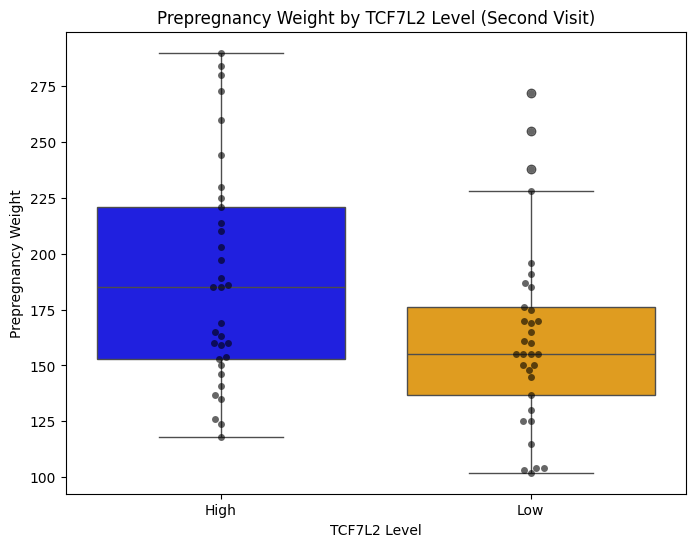

In [70]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='TCF7L2_Level', y='Prepregnancy_Weight', data=second_visit_prepreg_tcf, palette={'High': 'blue', 'Low': 'orange'})
sns.swarmplot(x='TCF7L2_Level', y='Prepregnancy_Weight', data=second_visit_prepreg_tcf, color='black', alpha=0.6)
plt.title('Prepregnancy Weight by TCF7L2 Level (Second Visit)')
plt.xlabel('TCF7L2 Level')
plt.ylabel('Prepregnancy Weight')
plt.show()


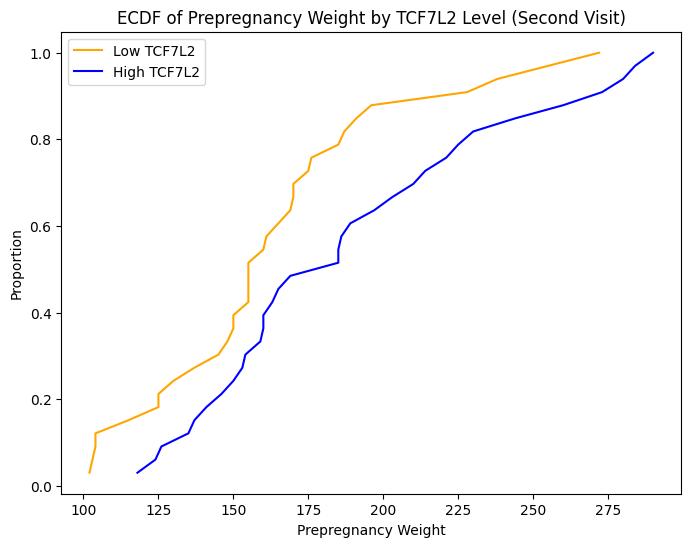

In [71]:
low_tcf = second_visit_prepreg_tcf[second_visit_prepreg_tcf['TCF7L2_Level'] == 'Low']['Prepregnancy_Weight']
high_tcf = second_visit_prepreg_tcf[second_visit_prepreg_tcf['TCF7L2_Level'] == 'High']['Prepregnancy_Weight']

ecdf_low = ECDF(low_tcf)
ecdf_high = ECDF(high_tcf)

plt.figure(figsize=(8, 6))
plt.plot(ecdf_low.x, ecdf_low.y, label='Low TCF7L2', color='orange')
plt.plot(ecdf_high.x, ecdf_high.y, label='High TCF7L2', color='blue')
plt.title('ECDF of Prepregnancy Weight by TCF7L2 Level (Second Visit)')
plt.xlabel('Prepregnancy Weight')
plt.ylabel('Proportion')
plt.legend()
plt.show()


### Insights
* The Boxplot visualizes the difference in median prepregnancy weights for patients with high and low TCF7L2 levels. Patients with higher levels have a heavier current weight and patients with lower levels have a lighter prepregnancy weight at the second visit.
* The Empirical Cumulative Distribution Functioin (ECDF) plot confirms that patients with lower TCF7L2 levels generally have lower prepregnancy weights while patients with higher TCF7L2 levels generally have higher prepregnancy weights for the second visit sample of the data since the distribution of prepregnancy weight for patients with low TCF7L2 is consistenly to the left of that for patients with high levels.
* Although there is a statistically significant difference between the median second visit prepregnancy weight for patients with high and low TCF7L2 levels, there is not a linear relationship between prepregnancy weight and TCF7L2 levels for the second visit.

### Second Visit Current Weight by TCF7L2 Levels

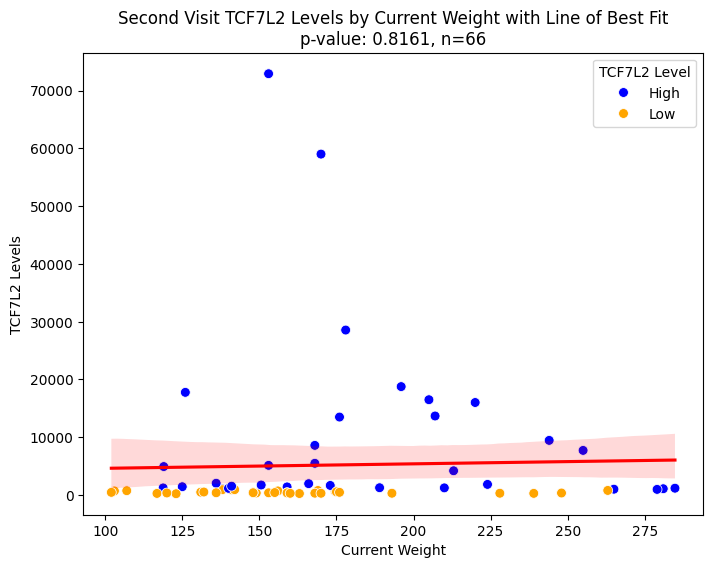

In [72]:
plt.figure(figsize=(8, 6))

# Drop rows where Current Weight or the TCF7L2 protein level is NaN
second_visit_current_tcf = second_visit.dropna(subset=['Current_Weight', 'TCF7L2'])

# Define a threshold for high and low TCF7L2 levels (e.g., the median)
threshold = second_visit_current_tcf['TCF7L2'].median()
second_visit_current_tcf['TCF7L2_Level'] = np.where(second_visit_current_tcf['TCF7L2'] > threshold, 'High', 'Low')

# Scatter plot with points colored by TCF7L2 levels
sns.scatterplot(
    x='Current_Weight',
    y='TCF7L2',
    data=second_visit_current_tcf,
    hue='TCF7L2_Level',
    palette={'High': 'blue', 'Low': 'orange'},
    s=50
)

# Add the line of best fit
sns.regplot(
    x='Current_Weight',
    y='TCF7L2',
    data=second_visit_current_tcf,
    scatter=False,  # Don't plot scatter points again
    line_kws={'color': 'red'}
)

# Calculate the p-value and sample size (n)
slope, intercept, r_value, p_value, std_err = linregress(
    second_visit_current_tcf['Current_Weight'],
    second_visit_current_tcf['TCF7L2']
)
sample_size = second_visit_current_tcf.shape[0]  # Number of valid data points (rows)

# Display the p-value and sample size (n) in the plot
plt.title(f"Second Visit TCF7L2 Levels by Current Weight with Line of Best Fit\np-value: {p_value:.4f}, n={sample_size}")
plt.xlabel("Current Weight")
plt.ylabel("TCF7L2 Levels")

# Show legend
plt.legend(title="TCF7L2 Level")

# Show the plot
plt.show()

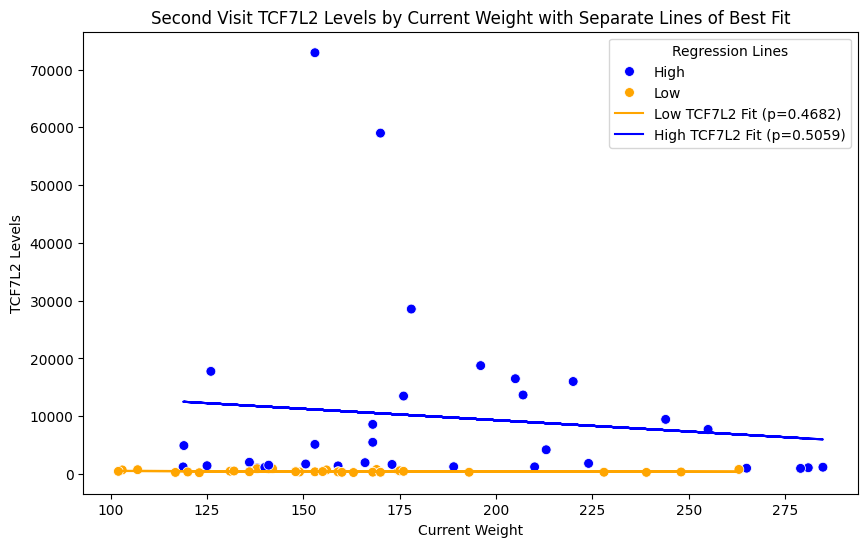

In [73]:
# Drop rows where Current Weight or the TCF7L2 protein level is NaN
second_visit_current_tcf = second_visit.dropna(subset=['Current_Weight', 'TCF7L2'])

# Define a threshold for high and low TCF7L2 levels (e.g., the median)
threshold = second_visit_current_tcf['TCF7L2'].median()
second_visit_current_tcf['TCF7L2_Level'] = np.where(second_visit_current_tcf['TCF7L2'] > threshold, 'High', 'Low')

# Initialize the plot
plt.figure(figsize=(10, 6))

# Scatter plot with points colored by TCF7L2 levels
sns.scatterplot(
    x='Current_Weight',
    y='TCF7L2',
    data=second_visit_current_tcf,
    hue='TCF7L2_Level',
    palette={'High': 'blue', 'Low': 'orange'},
    s=50
)

# Separate the data into two groups
low_group = second_visit_current_tcf[second_visit_current_tcf['TCF7L2_Level'] == 'Low']
high_group = second_visit_current_tcf[second_visit_current_tcf['TCF7L2_Level'] == 'High']

# Perform linear regression and plot the line of best fit for the "Low" group
slope_low, intercept_low, _, p_value_low, _ = linregress(low_group['Current_Weight'], low_group['TCF7L2'])
plt.plot(
    low_group['Current_Weight'],
    slope_low * low_group['Current_Weight'] + intercept_low,
    color='orange',
    label=f'Low TCF7L2 Fit (p={p_value_low:.4f})'
)

# Perform linear regression and plot the line of best fit for the "High" group
slope_high, intercept_high, _, p_value_high, _ = linregress(high_group['Current_Weight'], high_group['TCF7L2'])
plt.plot(
    high_group['Current_Weight'],
    slope_high * high_group['Current_Weight'] + intercept_high,
    color='blue',
    label=f'High TCF7L2 Fit (p={p_value_high:.4f})'
)

# Customize the plot
plt.title("Second Visit TCF7L2 Levels by Current Weight with Separate Lines of Best Fit")
plt.xlabel("Current Weight")
plt.ylabel("TCF7L2 Levels")
plt.legend(title="Regression Lines")
plt.show()


/var/folders/83/nfh4vv717vs1mrzz_kl1vthh0000gn/T/ipykernel_3333/1268935204.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='TCF7L2_Level', y='Current_Weight', data=second_visit_current_tcf, palette={'High': 'blue', 'Low': 'orange'})


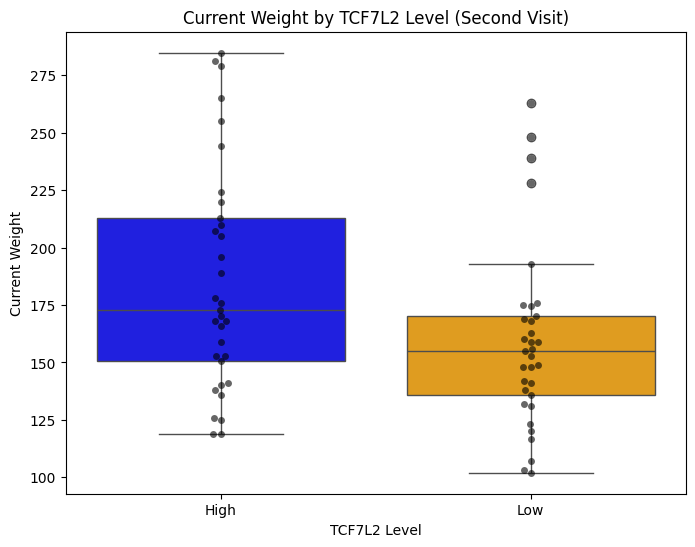

In [74]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='TCF7L2_Level', y='Current_Weight', data=second_visit_current_tcf, palette={'High': 'blue', 'Low': 'orange'})
sns.swarmplot(x='TCF7L2_Level', y='Current_Weight', data=second_visit_current_tcf, color='black', alpha=0.6)
plt.title('Current Weight by TCF7L2 Level (Second Visit)')
plt.xlabel('TCF7L2 Level')
plt.ylabel('Current Weight')
plt.show()

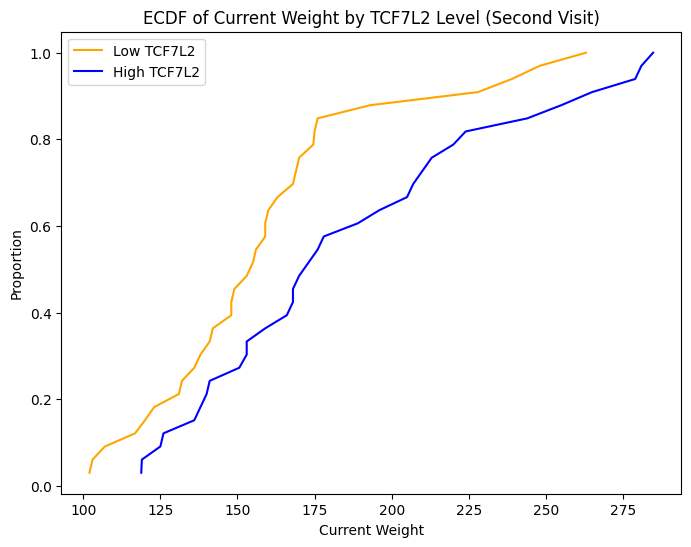

In [75]:
low_tcf = second_visit_current_tcf[second_visit_current_tcf['TCF7L2_Level'] == 'Low']['Current_Weight']
high_tcf = second_visit_current_tcf[second_visit_current_tcf['TCF7L2_Level'] == 'High']['Current_Weight']

ecdf_low = ECDF(low_tcf)
ecdf_high = ECDF(high_tcf)

plt.figure(figsize=(8, 6))
plt.plot(ecdf_low.x, ecdf_low.y, label='Low TCF7L2', color='orange')
plt.plot(ecdf_high.x, ecdf_high.y, label='High TCF7L2', color='blue')
plt.title('ECDF of Current Weight by TCF7L2 Level (Second Visit)')
plt.xlabel('Current Weight')
plt.ylabel('Proportion')
plt.legend()
plt.show()

### Insights
* The Boxplot visualizes the difference in median current weights for patients with high and low TCF7L2 levels. Patients with higher levels have a heavier current weight and patients with lower levels have a lighter current weight at the second visit.
* The Empirical Cumulative Distribution Functioin (ECDF) plot confirms that patients with lower TCF7L2 levels generally have lighter current weights while patients with higher TCF7L2 levels generally have heavier current weights for the second visit sample of the data since the distribution of current weight for patients with low TCF7L2 is consistenly to the left of that for patients with high levels.
* Although there is a statistically significant difference between the median second visit current weight for patients with high and low TCF7L2 levels, there is not a linear relationship between current weight and TCF7L2 levels for the second visit.

### Check for significant differences between low and high TCF7L2 levels separated at the top quartile
* Using only rows with TCF7L2 data
* Using only rows with non null values
* Filter for first and second visits
* Split data into high and low TCF7L2 levels at the top quartile
* Calculate median EGA, HELP, PUQE, Prepregnancy Weight, Visit Weight, Weight Change from Prepregnancy, Weight Change from Last Visit for high and low TCF7L2 groups
* Test if there is a statistically signficant difference between the medians
    * Check that data is approx normal and has similar variance to meet assumptions of indepedent t-test otherwise use Mann-Whitney U test

In [76]:
# Filter the data for 1st and 2nd visits including subset with only first visits for those that also have second visits
first_visit = tcf7l2_first_visit
second_visit = tcf_with_2nd_visit[tcf_with_2nd_visit['Visit_Number'] == 2]
first_visit_with_second = tcf_with_2nd_visit[tcf_with_2nd_visit['Visit_Number'] == 1]

# Calculate the 75th percentile (top quartile) of TCF7L2 for both first and second visits
top_quartile_threshold_first = first_visit['TCF7L2'].quantile(0.75)
top_quartile_threshold_second = second_visit['TCF7L2'].quantile(0.75)

# Split the data into High and Low TCF7L2 groups based on the top quartile threshold
first_visit['TCF_Group'] = ['High' if x >= top_quartile_threshold_first else 'Low' for x in first_visit['TCF7L2']]
second_visit['TCF_Group'] = ['High' if x >= top_quartile_threshold_second else 'Low' for x in second_visit['TCF7L2']]

# Define the metrics we want to analyze
metrics_to_analyze = [
    "EGA_Weeks", "HELP", "PUQE", "Prepregnancy_Weight", "Current_Weight", 
    "Weight_Change_from_Prepregnancy", "Weight_Change_from_Last_Visit", 
    "TCF7L2"
]

# Initialize an empty list to store the summary data
summary_data = []

# Function to calculate median, sample size, and perform normality check
def calculate_summary(data, metric):
    high_values = data[data['TCF_Group'] == 'High'][metric].dropna()
    low_values = data[data['TCF_Group'] == 'Low'][metric].dropna()
    
    # Sample sizes
    sample_size_high = len(high_values)
    sample_size_low = len(low_values)
    
    # Skip normality test if either group has fewer than 3 values
    if sample_size_high < 3 or sample_size_low < 3:
        test_used = "Not enough data for normality test"
        p_value = None
        significant = "Insufficient data"
        median_high = high_values.median() if sample_size_high > 0 else "N/A"
        median_low = low_values.median() if sample_size_low > 0 else "N/A"
        return median_high, median_low, significant, test_used, sample_size_high, sample_size_low, p_value
    
    # Check normality
    normal_high = shapiro(high_values)[1] >= 0.05
    normal_low = shapiro(low_values)[1] >= 0.05
    
    # Determine which test to use
    if normal_high and normal_low:
        # Use t-test if both groups are normal
        t_stat, p_value = ttest_ind(high_values, low_values, nan_policy='omit')
        test_used = "t-test"
    else:
        # Use Mann-Whitney U test if not normal
        t_stat, p_value = mannwhitneyu(high_values, low_values, alternative='two-sided')
        test_used = "Mann-Whitney U"

    # Calculate medians
    median_high = high_values.median()
    median_low = low_values.median()
    
    # Check if the difference is significant
    significant = "Yes" if p_value < 0.05 else "No"
    
    return median_high, median_low, significant, test_used, sample_size_high, sample_size_low, p_value

# Perform the analysis for each metric
for metric in metrics_to_analyze:
    # For first visit
    median_high_first, median_low_first, significant_first, test_used_first, sample_size_high_first, sample_size_low_first, p_value_first = calculate_summary(first_visit, metric)
    
    # For second visit
    median_high_second, median_low_second, significant_second, test_used_second, sample_size_high_second, sample_size_low_second, p_value_second = calculate_summary(second_visit, metric)

    # Add the results to the summary data list
    summary_data.append({
        "Metric": f"{metric} - 1st Visit High vs Low TCF7L2", 
        "Median (High)": median_high_first, 
        "Median (Low)": median_low_first,
        "Significant Difference (p < 0.05)": significant_first,
        "Test Used": test_used_first,
        "Sample Size (High)": sample_size_high_first,
        "Sample Size (Low)": sample_size_low_first,
        "p-value": p_value_first 
    })
    
    summary_data.append({
        "Metric": f"{metric} - 2nd Visit High vs Low TCF7L2", 
        "Median (High)": median_high_second, 
        "Median (Low)": median_low_second,
        "Significant Difference (p < 0.05)": significant_second,
        "Test Used": test_used_second,
        "Sample Size (High)": sample_size_high_second,
        "Sample Size (Low)": sample_size_low_second,
        "p-value": p_value_second 
    })

# Convert the list of dictionaries into a DataFrame
summary_table = pd.DataFrame(summary_data)

# Display the updated summary table
summary_table
# Export the table if needed
# summary_table.to_excel('tcf_high_low_quartile_table.xlsx', index=False)


/var/folders/83/nfh4vv717vs1mrzz_kl1vthh0000gn/T/ipykernel_3333/1244328184.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  first_visit['TCF_Group'] = ['High' if x >= top_quartile_threshold_first else 'Low' for x in first_visit['TCF7L2']]
/var/folders/83/nfh4vv717vs1mrzz_kl1vthh0000gn/T/ipykernel_3333/1244328184.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_visit['TCF_Group'] = ['High' if x >= top_quartile_threshold_second else 'Low' for x in second_visit['TCF7L2']]


,Metric,Median (High),Median (Low),Significant Difference (p < 0.05),Test Used,Sample Size (High),Sample Size (Low),p-value
0,EGA_Weeks - 1st Visit High vs Low TCF7L2,9.5,9.0,No,Mann-Whitney U,18,59,7.530035e-01
1,EGA_Weeks - 2nd Visit High vs Low TCF7L2,11.1,12.0,No,Mann-Whitney U,17,49,7.083730e-01
2,HELP - 1st Visit High vs Low TCF7L2,30.0,34.0,Yes,Mann-Whitney U,18,60,4.262105e-02
3,HELP - 2nd Visit High vs Low TCF7L2,25.0,25.0,No,t-test,17,49,6.926530e-01
4,PUQE - 1st Visit High vs Low TCF7L2,10.0,11.0,Yes,Mann-Whitney U,21,60,9.869656e-03
5,PUQE - 2nd Visit High vs Low TCF7L2,9.0,8.5,No,Mann-Whitney U,17,48,6.744350e-01
6,Prepregnancy_Weight - 1st Visit High vs Low TC...,185.0,164.0,No,Mann-Whitney U,21,60,4.004723e-01
7,Prepregnancy_Weight - 2nd Visit High vs Low TC...,185.0,160.0,No,Mann-Whitney U,17,49,2.071613e-01
8,Current_Weight - 1st Visit High vs Low TCF7L2,173.5,155.0,No,Mann-Whitney U,18,59,1.626073e-01
9,Current_Weight - 2nd Visit High vs Low TCF7L2,176.0,159.0,No,Mann-Whitney U,17,49,1.404990e-01


### Insights
Splitting by Top Quartile (High TCF7L2: top quartile, Low TCF7L2: bottom 3 quartiles):
* First Visit:
    * Significant Difference between high and low TCF7L2 median HELP score.
    * Significant Difference between high and low TCF7L2 median PUQE score.
* Second Visit:
    * No significant difference between the groups.
  
1. First Visit HELP and PUQE Scores (Top Quartile Split):
    *  The top quartile of TCF7L2 levels appears to show significant differences in both HELP and PUQE scores when compared with the bottom three quartiles.
    * This suggests that higher levels of TCF7L2 may be associated with variations in these symptoms or outcomes, specifically at the first visit.
    * The differences observed when splitting by top quartile might indicate a more distinct, higher impact for extreme values of TCF7L2 (those in the top quartile).

### Check for significant differences between low and high TCF7L2 levels separated at the lowest quartile
* Using only rows with TCF7L2 data
* Using only rows with non null values
* Filter for first and second visits
* Split data into high and low TCF7L2 levels at the top quartile
* Calculate median EGA, HELP, PUQE, Prepregnancy Weight, Visit Weight, Weight Change from Prepregnancy, Weight Change from Last Visit for high and low TCF7L2 groups
* Test if there is a statistically signficant difference between the medians
    * Check that data is approx normal and has similar variance to meet assumptions of indepedent t-test otherwise use Mann-Whitney U test

In [77]:
# Filter the data for 1st and 2nd visits including subset with only first visits for those that also have second visits
first_visit = tcf7l2_first_visit
second_visit = tcf_with_2nd_visit[tcf_with_2nd_visit['Visit_Number'] == 2]
first_visit_with_second = tcf_with_2nd_visit[tcf_with_2nd_visit['Visit_Number'] == 1]

# Calculate the 25th percentile (lower quartile) of TCF7L2 for both first and second visits
lower_quartile_threshold_first = first_visit['TCF7L2'].quantile(0.25)
lower_quartile_threshold_second = second_visit['TCF7L2'].quantile(0.25)

# Split the data into "Low" (bottom 25%) and "Rest" (>25%)
first_visit['TCF_Group'] = ['Low' if x <= lower_quartile_threshold_first else 'Rest' for x in first_visit['TCF7L2']]
second_visit['TCF_Group'] = ['Low' if x <= lower_quartile_threshold_second else 'Rest' for x in second_visit['TCF7L2']]

# Define the metrics we want to analyze
metrics_to_analyze = [
    "EGA_Weeks", "HELP", "PUQE", "Prepregnancy_Weight", "Current_Weight", 
    "Weight_Change_from_Prepregnancy", "Weight_Change_from_Last_Visit", 
    "TCF7L2"
]

# Initialize an empty list to store the summary data
summary_data = []

# Function to calculate median, sample size, and perform normality check
def calculate_summary(data, metric):
    low_values = data[data['TCF_Group'] == 'Low'][metric].dropna()
    rest_values = data[data['TCF_Group'] == 'Rest'][metric].dropna()
    
    # Sample sizes
    sample_size_low = len(low_values)
    sample_size_rest = len(rest_values)
    
    # Skip normality test if either group has fewer than 3 values
    if sample_size_low < 3 or sample_size_rest < 3:
        test_used = "Not enough data for normality test"
        p_value = None
        significant = "Insufficient data"
        median_low = low_values.median() if sample_size_low > 0 else "N/A"
        median_rest = rest_values.median() if sample_size_rest > 0 else "N/A"
        return median_low, median_rest, significant, test_used, sample_size_low, sample_size_rest, p_value
    
    # Check normality
    normal_low = shapiro(low_values)[1] >= 0.05
    normal_rest = shapiro(rest_values)[1] >= 0.05
    
    # Determine which test to use
    if normal_low and normal_rest:
        # Use t-test if both groups are normal
        t_stat, p_value = ttest_ind(low_values, rest_values, nan_policy='omit')
        test_used = "t-test"
    else:
        # Use Mann-Whitney U test if not normal
        t_stat, p_value = mannwhitneyu(low_values, rest_values, alternative='two-sided')
        test_used = "Mann-Whitney U"

    # Calculate medians
    median_low = low_values.median()
    median_rest = rest_values.median()
    
    # Check if the difference is significant
    significant = "Yes" if p_value < 0.05 else "No"
    
    return median_low, median_rest, significant, test_used, sample_size_low, sample_size_rest, p_value

# Perform the analysis for each metric
for metric in metrics_to_analyze:
    # For first visit
    median_low_first, median_rest_first, significant_first, test_used_first, sample_size_rest_first, sample_size_low_first, p_value_first = calculate_summary(first_visit, metric)
    
    # For second visit
    median_low_second, median_rest_second, significant_second, test_used_second, sample_size_rest_second, sample_size_low_second, p_value_second = calculate_summary(second_visit, metric)
       
    # Add the results to the summary data list
    summary_data.append({
        "Metric": f"{metric} - 1st Visit Low vs Rest", 
        "Median (Low)": median_low_first, 
        "Median (Rest)": median_rest_first,
        "Significant Difference (p < 0.05)": significant_first,
        "Test Used": test_used_first,
        "Sample Size (Low)": sample_size_low_first,
        "Sample Size (Rest)": sample_size_rest_first,
        "p_value": p_value_first
    })
    
    summary_data.append({
        "Metric": f"{metric} - 2nd Visit Low vs Rest", 
        "Median (Low)": median_low_second, 
        "Median (Rest)": median_rest_second,
        "Significant Difference (p < 0.05)": significant_second,
        "Test Used": test_used_second,
        "Sample Size (Low)": sample_size_low_second,
        "Sample Size (Rest)": sample_size_rest_second,
        "p_value": p_value_second

    })

# Convert the list of dictionaries into a DataFrame
summary_table = pd.DataFrame(summary_data)

# Display the updated summary table
summary_table
# Export the table if needed
# summary_table.to_excel('tcf_low_vs_rest_quartile_table.xlsx', index=False)

/var/folders/83/nfh4vv717vs1mrzz_kl1vthh0000gn/T/ipykernel_3333/35382880.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  first_visit['TCF_Group'] = ['Low' if x <= lower_quartile_threshold_first else 'Rest' for x in first_visit['TCF7L2']]
/var/folders/83/nfh4vv717vs1mrzz_kl1vthh0000gn/T/ipykernel_3333/35382880.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_visit['TCF_Group'] = ['Low' if x <= lower_quartile_threshold_second else 'Rest' for x in second_visit['TCF7L2']]


,Metric,Median (Low),Median (Rest),Significant Difference (p < 0.05),Test Used,Sample Size (Low),Sample Size (Rest),p_value
0,EGA_Weeks - 1st Visit Low vs Rest,9.5,9.0,No,Mann-Whitney U,57,20,8.062113e-01
1,EGA_Weeks - 2nd Visit Low vs Rest,13.6,11.1,Yes,Mann-Whitney U,49,17,3.049682e-02
2,HELP - 1st Visit Low vs Rest,36.0,32.0,No,t-test,57,21,1.972571e-01
3,HELP - 2nd Visit Low vs Rest,19.0,25.0,No,t-test,49,17,4.179862e-01
4,PUQE - 1st Visit Low vs Rest,13.0,11.0,Yes,Mann-Whitney U,61,20,1.762669e-02
5,PUQE - 2nd Visit Low vs Rest,8.5,9.0,No,t-test,49,16,7.291456e-01
6,Prepregnancy_Weight - 1st Visit Low vs Rest,160.0,166.0,No,Mann-Whitney U,61,20,9.921928e-02
7,Prepregnancy_Weight - 2nd Visit Low vs Rest,165.0,163.0,No,Mann-Whitney U,49,17,7.029388e-01
8,Current_Weight - 1st Visit Low vs Rest,152.0,166.5,Yes,Mann-Whitney U,56,21,3.530714e-02
9,Current_Weight - 2nd Visit Low vs Rest,159.0,168.0,No,Mann-Whitney U,49,17,6.026149e-01


### Insights
Splitting by Lowest Quartile (High TCF7L2: top 3 quartiles, Low TCF7L2: bottom quartile):

EGA_Weeks (2nd visit):
* Median (Low quartile): 11.1 
* Median (Rest): 13.6
* Suggests that individuals in the lower quartile of TCF7L2 tend to have earlier gestational ages at the second visit.

PUQE (1st visit):
* Median (Low quartile): 13
* Median (Rest): 11
* Higher PUQE scores in the lower quartile group indicate they experience more severe nausea/vomiting during pregnancy.

Current Weight (1st visit):
* Median (Low quartile): 152
* Median (Rest): 166.5
* Participants in the lower quartile of TCF7L2 tend to have significantly lower weight at the first visit which could indicate greater HG severity.

## Overall TCF7L2 Insights
Comparison & Implications:
* Higher TCF7L2 Levels: Associated with better pregnancy outcomes in some respects (e.g., less severe symptoms like nausea/vomiting), but the differences become less pronounced over time.
* Lower TCF7L2 Levels: Associated with more severe pregnancy symptoms (e.g., higher PUQE scores), lower weight, and earlier gestational age, which may point to greater vulnerability or risk during pregnancy for those in the lower quartile.

Overall Interpretation:
* The lower quartile group appears to experience more severe pregnancy-related challenges (e.g., earlier gestational age, more severe nausea, lower weight), while the higher quartile group seems to fare better in terms of pregnancy health metrics like nausea severity and weight gain. This suggests that TCF7L2 may play a role in influencing pregnancy outcomes, with lower levels potentially being linked to adverse conditions.

## TCF7L2 and GDF15
* Investigate whether there is an inverse relationship (or anti-correlation) between two variables: Top Quartile TCF levels and GDF15 levels. Specifically, check if those individuals who have the highest 25% of TCF levels (i.e., those in the top quartile) tend to have lower levels of GDF15.

#### First Visit

In [78]:
# Filter the data for 1st and 2nd visits
first_visit = tcf7l2_first_visit
second_visit = tcf_with_2nd_visit[tcf_with_2nd_visit['Visit_Number'] == 2]

# Define the top quartile for TCF levels
top_quartile_tcf = first_visit['TCF7L2'].quantile(0.75)

# Filter data for individuals in the top quartile of TCF levels
top_tcf_data = first_visit[first_visit['TCF7L2'] > top_quartile_tcf]

# Calculate the correlation between TCF levels and GDF15 levels for this subset
correlation, p_value = pearsonr(top_tcf_data['TCF7L2'], top_tcf_data['GDF15'])

# Display the correlation result
print(f"Correlation coefficient: {correlation}, p-value: {p_value}")

Correlation coefficient: -0.16640263300986108, p-value: 0.47096535811126444


#### Second Visit

In [79]:
# Filter the data for 1st and 2nd visits
first_visit = tcf7l2_first_visit
second_visit = tcf_with_2nd_visit[tcf_with_2nd_visit['Visit_Number'] == 2]

# Define the top quartile for TCF levels
top_quartile_tcf = second_visit['TCF7L2'].quantile(0.75)

# Filter data for individuals in the top quartile of TCF levels
top_tcf_data = second_visit[second_visit['TCF7L2'] > top_quartile_tcf]

# Calculate the correlation between TCF levels and GDF15 levels for this subset
correlation, p_value = pearsonr(top_tcf_data['TCF7L2'], top_tcf_data['GDF15'])

# Display the correlation result
print(f"Correlation coefficient: {correlation}, p-value: {p_value}")

Correlation coefficient: -0.13287979255834648, p-value: 0.6111658341186306


### Insights
* There is not a statistically signficant anti-correlation between the top quartile TCF7L2 levels and GDF15 levels for the first nor second visit.

## TCF7L2 Levels vs Weight

First Visit Correlation (Weight vs TCF): -0.0349805514070363, p-value: 0.7626330815660983
Second Visit Correlation (Weight vs TCF): 0.029181125293744607, p-value: 0.8160809583640566


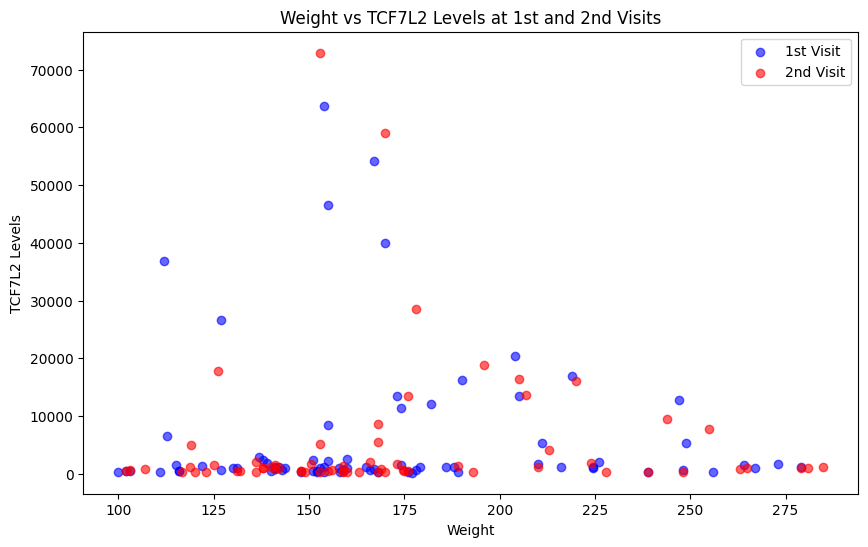

In [80]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

# Remove rows where TCF7L2 or Weight are NaN for both visits
first_visit_clean = first_visit.dropna(subset=['TCF7L2', 'Current_Weight'])
second_visit_clean = second_visit.dropna(subset=['TCF7L2', 'Current_Weight'])

# Calculate Pearson correlation between Weight and TCF for both visits
correlation_first, p_value_first = pearsonr(first_visit_clean['Current_Weight'], first_visit_clean['TCF7L2'])
correlation_second, p_value_second = pearsonr(second_visit_clean['Current_Weight'], second_visit_clean['TCF7L2'])

# Print correlation values for both visits
print(f"First Visit Correlation (Weight vs TCF): {correlation_first}, p-value: {p_value_first}")
print(f"Second Visit Correlation (Weight vs TCF): {correlation_second}, p-value: {p_value_second}")

# Plotting the data
plt.figure(figsize=(10, 6))

# Scatter plot for first visit (all points one color)
plt.scatter(first_visit_clean['Current_Weight'], first_visit_clean['TCF7L2'], color='blue', label='1st Visit', alpha=0.6)

# Scatter plot for second visit (all points another color)
plt.scatter(second_visit_clean['Current_Weight'], second_visit_clean['TCF7L2'], color='red', label='2nd Visit', alpha=0.6)

# Adding labels and title
plt.xlabel('Weight')
plt.ylabel('TCF7L2 Levels')
plt.title('Weight vs TCF7L2 Levels at 1st and 2nd Visits')

# Add a legend to distinguish between the visits
plt.legend()

# Show the plot
plt.show()


### Insights
* No statistically significant linear relationship between weight and TCF7L2 levels for the first nor second visit.

## TCF7L2 by Population 
* TCF7L2 levels by population for first and second visit

In [81]:
# Drop Latinx due to insufficient data 
first_visit_tcf_pop = first_visit[first_visit['Race'] != "latina"]
second_visit_tcf_pop = second_visit[second_visit['Race'] != "latina"]

# Function for boxplots to analyze race and attributes
def race_boxplot_tcf(col, df):
    sns.boxplot(data=df, x='Race', y=col, palette='Set2')
    plt.title(col + " by Race")

### First visit TCF7L2 levels by race

/var/folders/83/nfh4vv717vs1mrzz_kl1vthh0000gn/T/ipykernel_3333/2430381993.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Race', y=col, palette='Set2')


Text(0.5, 1.0, 'First Visit TCF7L2 by Race')

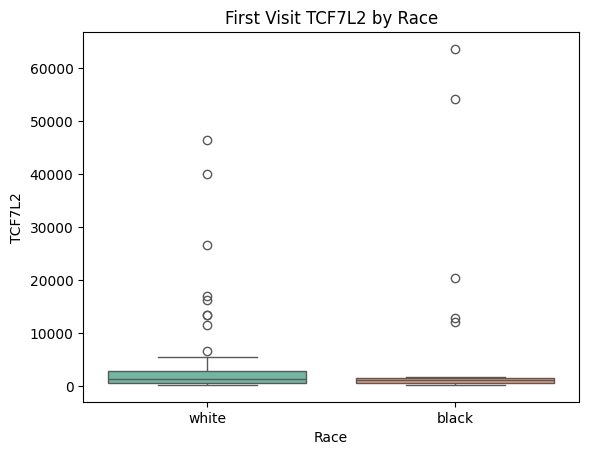

In [82]:
race_boxplot_tcf('TCF7L2', first_visit_tcf_pop)
plt.title("First Visit TCF7L2 by Race")

In [83]:
perform_statistical_tests(
    data=first_visit_tcf_pop, 
    group_column='Race', 
    value_column='TCF7L2', 
    group1='black', 
    group2='white'
)

Shapiro-Wilk test for black: p-value = 1.0901312408629601e-08
Shapiro-Wilk test for white: p-value = 2.6921400803884143e-11
At least one group is not normally distributed. Performing Mann-Whitney U test.
Mann-Whitney U test result: U-statistic = 571.0, p-value = 0.46588574650300363


### Second visit TCF7L2 levles by race

/var/folders/83/nfh4vv717vs1mrzz_kl1vthh0000gn/T/ipykernel_3333/2430381993.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Race', y=col, palette='Set2')


Text(0.5, 1.0, 'Second Visit TCF7L2 by Race')

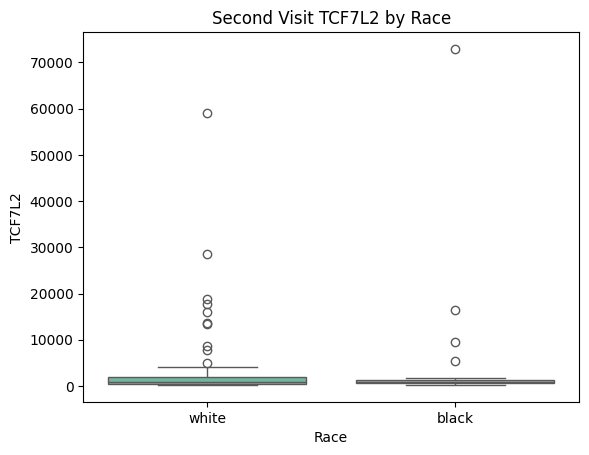

In [84]:
race_boxplot_tcf('TCF7L2', second_visit_tcf_pop)
plt.title("Second Visit TCF7L2 by Race")

In [85]:
perform_statistical_tests(
    data=second_visit_tcf_pop, 
    group_column='Race', 
    value_column='TCF7L2', 
    group1='black', 
    group2='white'
)

Shapiro-Wilk test for black: p-value = 2.7705051092466923e-08
Shapiro-Wilk test for white: p-value = 2.991115969390949e-11
At least one group is not normally distributed. Performing Mann-Whitney U test.
Mann-Whitney U test result: U-statistic = 450.0, p-value = 1.0


## TCF7L2 by Gestational Age 
* TCF7L2 levels by EGA in weeks for first and second visit
* Use dataframe `first_visit` & `second_visit`
* Analyze EGA < 20 weeks

### First Visit TCF7L2 by EGA

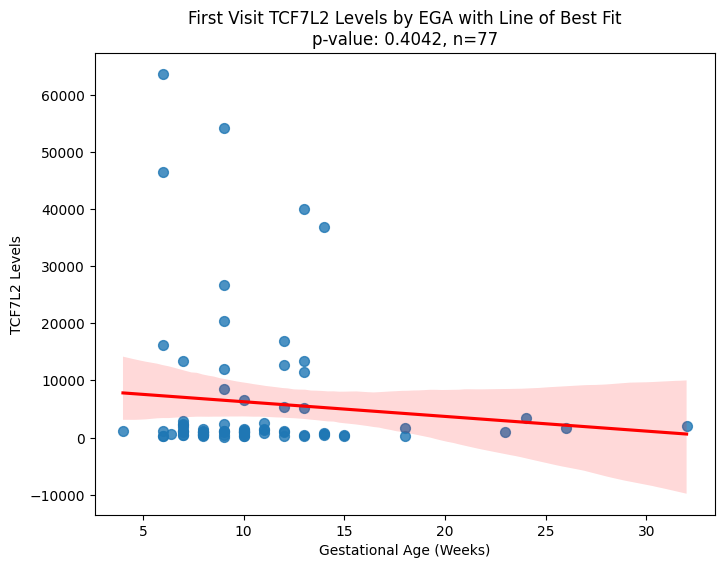

In [86]:
plt.figure(figsize=(8, 6))

# Drop rows where EGA or the current protein level is NaN
clean_first_visit_ega_tcf = first_visit.dropna(subset=['EGA_Weeks', protein])

# Scatter plot with line of best fit
sns.regplot(x='EGA_Weeks', y='TCF7L2', data=clean_first_visit_ega_tcf, scatter_kws={'s': 50}, line_kws={'color': 'red'})
    
# Calculate the p-value and sample size (n)
slope, intercept, r_value, p_value, std_err = linregress(clean_first_visit_ega_tcf['EGA_Weeks'], clean_first_visit_ega_tcf['TCF7L2'])
sample_size = clean_first_visit_ega_tcf.shape[0]  # Number of valid data points (rows)

# Display the p-value and sample size (n) in the plot
plt.title(f"First Visit TCF7L2 Levels by EGA with Line of Best Fit\np-value: {p_value:.4f}, n={sample_size}")
plt.xlabel("Gestational Age (Weeks)")
plt.ylabel(f"{'TCF7L2'} Levels")
    
# Show the plot
plt.show()

### Second Visit TCF7L2 by EGA

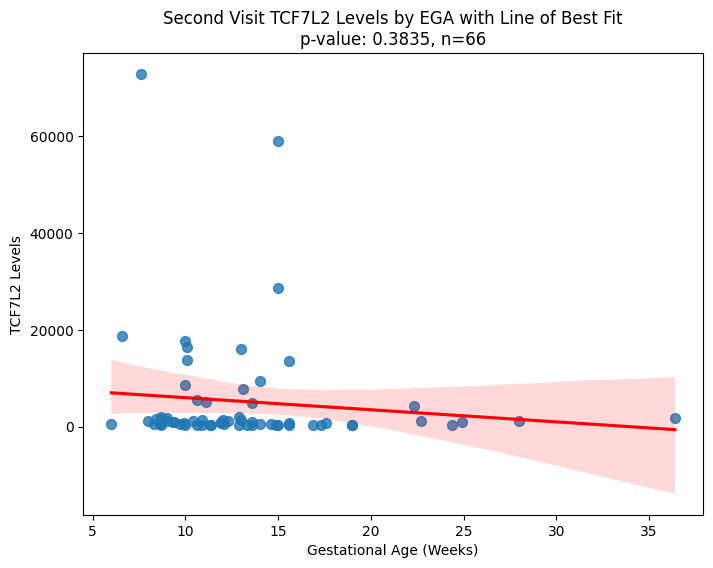

In [87]:
plt.figure(figsize=(8, 6))

# Drop rows where EGA or the current protein level is NaN
clean_second_visit_ega_tcf = second_visit.dropna(subset=['EGA_Weeks', protein])

# Scatter plot with line of best fit
sns.regplot(x='EGA_Weeks', y='TCF7L2', data=clean_second_visit_ega_tcf, scatter_kws={'s': 50}, line_kws={'color': 'red'})
    
# Calculate the p-value and sample size (n)
slope, intercept, r_value, p_value, std_err = linregress(clean_second_visit_ega_tcf['EGA_Weeks'], clean_second_visit_ega_tcf['TCF7L2'])
sample_size = clean_second_visit_ega_tcf.shape[0]  # Number of valid data points (rows)

# Display the p-value and sample size (n) in the plot
plt.title(f"Second Visit TCF7L2 Levels by EGA with Line of Best Fit\np-value: {p_value:.4f}, n={sample_size}")
plt.xlabel("Gestational Age (Weeks)")
plt.ylabel(f"{'TCF7L2'} Levels")
    
# Show the plot
plt.show()

### First Visit TCF7L2 by EGA < 20 Weeks

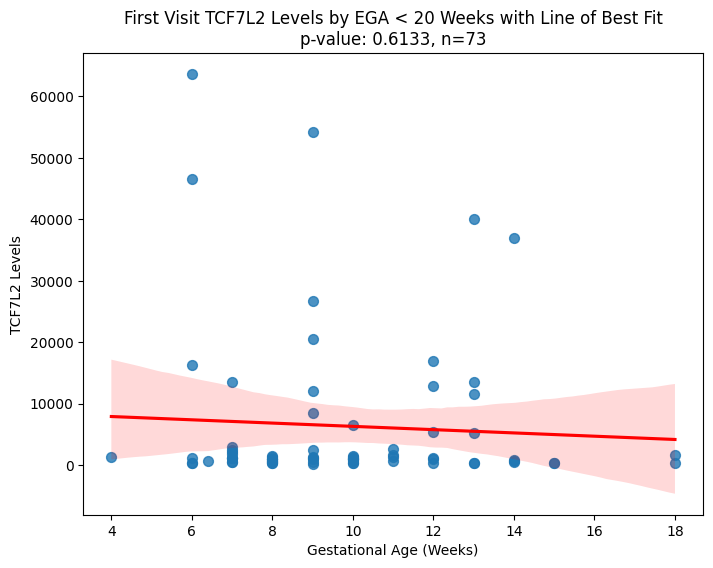

In [88]:
plt.figure(figsize=(8, 6))

# Drop rows where EGA or the current protein level is NaN
clean_first_visit_ega20_tcf = first_visit.dropna(subset=['EGA_Weeks', protein])
clean_first_visit_ega20_tcf = clean_first_visit_ega20_tcf[clean_first_visit_ega20_tcf['EGA_Weeks'] < 20]

# Scatter plot with line of best fit
sns.regplot(x='EGA_Weeks', y='TCF7L2', data=clean_first_visit_ega20_tcf, scatter_kws={'s': 50}, line_kws={'color': 'red'})
    
# Calculate the p-value and sample size (n)
slope, intercept, r_value, p_value, std_err = linregress(clean_first_visit_ega20_tcf['EGA_Weeks'], clean_first_visit_ega20_tcf['TCF7L2'])
sample_size = clean_first_visit_ega20_tcf.shape[0]  # Number of valid data points (rows)

# Display the p-value and sample size (n) in the plot
plt.title(f"First Visit TCF7L2 Levels by EGA < 20 Weeks with Line of Best Fit\np-value: {p_value:.4f}, n={sample_size}")
plt.xlabel("Gestational Age (Weeks)")
plt.ylabel(f"{'TCF7L2'} Levels")
    
# Show the plot
plt.show()

### Second Visit TCF7L2 by EGA < 20 Weeks

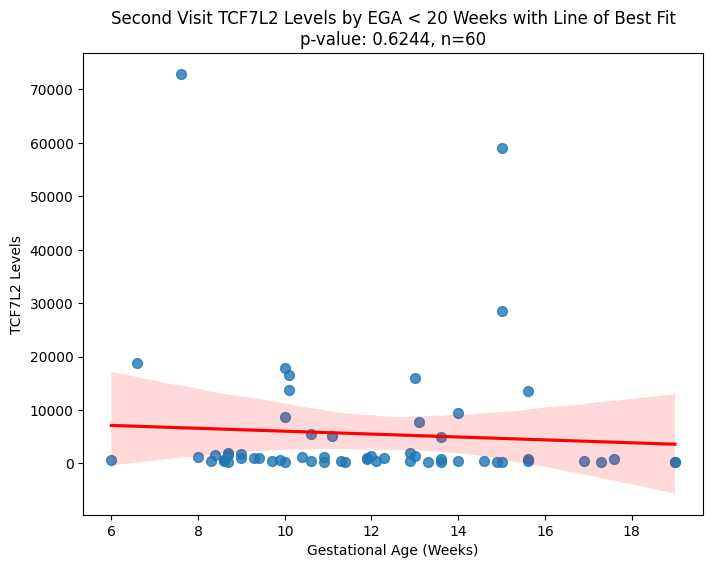

In [89]:
plt.figure(figsize=(8, 6))

# Drop rows where EGA or the current protein level is NaN
clean_second_visit_ega20_tcf = second_visit.dropna(subset=['EGA_Weeks', protein])
clean_second_visit_ega20_tcf = clean_second_visit_ega20_tcf[clean_second_visit_ega20_tcf['EGA_Weeks'] < 20]

# Scatter plot with line of best fit
sns.regplot(x='EGA_Weeks', y='TCF7L2', data=clean_second_visit_ega20_tcf, scatter_kws={'s': 50}, line_kws={'color': 'red'})
    
# Calculate the p-value and sample size (n)
slope, intercept, r_value, p_value, std_err = linregress(clean_second_visit_ega20_tcf['EGA_Weeks'], clean_second_visit_ega20_tcf['TCF7L2'])
sample_size = clean_second_visit_ega20_tcf.shape[0]  # Number of valid data points (rows)

# Display the p-value and sample size (n) in the plot
plt.title(f"Second Visit TCF7L2 Levels by EGA < 20 Weeks with Line of Best Fit\np-value: {p_value:.4f}, n={sample_size}")
plt.xlabel("Gestational Age (Weeks)")
plt.ylabel(f"{'TCF7L2'} Levels")
    
# Show the plot
plt.show()

### Insights
* No significant relationship between EGA and TCF7L2 levelsfor first nor second visit.